In this, we'll be going through old results and extracting 

1) the lda vector for each layer

2) the lda scaling for each layer 

the resulting combined output will then be constructed, with shape (31, 4096)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
import glob 
import os 
import re

In [2]:
def extract_layer_index(s):
    match = re.search(r'layer_(\d+)_analyses', s)
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"No layer index found in '{s}'")

In [3]:
def extract_reasoning_weight_information(layer_dir, save_location):
    """
    look within layer folder for results from layer 1 to 32 
    """ 
    all_folders = sorted(glob.glob(os.path.join(layer_dir,"layer_*/")), key=extract_layer_index)
    results = [None]*31

    for folder in all_folders:
        layer_idx = extract_layer_index(folder)
        if layer_idx>0:
            # get w vector 
            cur_w = np.load(
                os.path.join(folder, f"Layer_{layer_idx}_analysis_w_vector.npy")
            )

            # obtain the projected differences to determine the magntiude
            proj0 = np.load(
                os.path.join(folder, f"Layer_{layer_idx}_analysis_projected_0.npy")
            )
            proj1 = np.load(
                os.path.join(folder, f"Layer_{layer_idx}_analysis_projected_1.npy")
            )
            delta_mag = proj0.mean()-proj1.mean()

            results[layer_idx-1] = (delta_mag*cur_w)
    
    combined_results = np.stack(results)

    np.save(save_location, combined_results)

    return combined_results

Now let's extract this 

In [4]:
#combined_results = extract_reasoning_weight_information(layer_dir="layer_analyses", save_location="layer_analyses/combined_delta_vectors.npy")

combined_results = np.load("layer_analyses/combined_delta_vectors.npy")

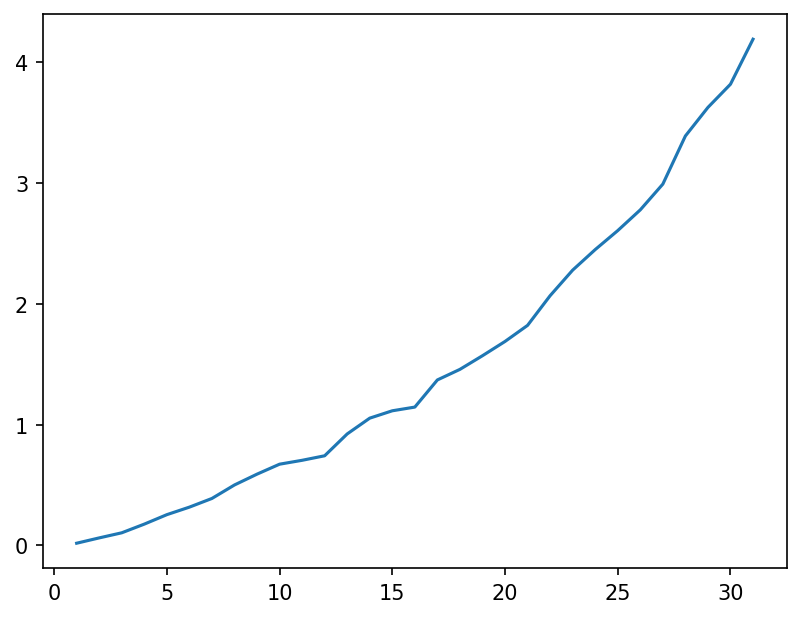

In [5]:
fig, ax = plt.subplots(dpi=150)

ax.plot(range(1, 32), np.sqrt((combined_results**2).sum(-1)))


In [6]:
def plot_cosine_similarity(matrix, title="Cosine Similarity Across Layers"):
    # Step 1: Normalize rows to unit length
    norms = np.linalg.norm(matrix, axis=1, keepdims=True)
    normalized = matrix / (norms + 1e-8)  # avoid divide-by-zero

    # Step 2: Cosine similarity = dot product of unit vectors
    cosine_sim = normalized @ normalized.T  # shape: (N, N)

    # Step 3: Plot with matplotlib
    plt.figure(figsize=(8, 6))
    im = plt.imshow(cosine_sim, cmap='viridis', interpolation='nearest')
    plt.title(title, fontsize=14)
    plt.xlabel("Layer Index")
    plt.ylabel("Layer Index")
    plt.colorbar(im, label='Cosine Similarity')
    plt.xticks(ticks=np.arange(len(matrix)))
    plt.yticks(ticks=np.arange(len(matrix)))
    plt.tight_layout()
    plt.show()


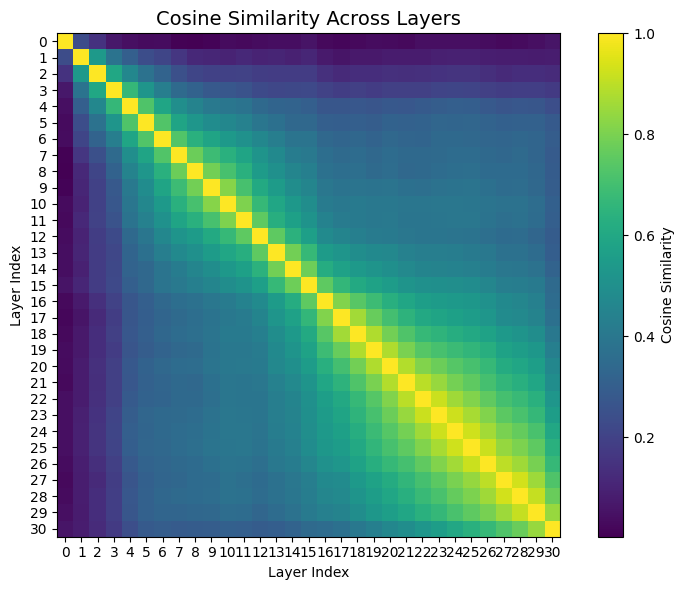

In [7]:
plot_cosine_similarity(combined_results)

# directional review

is this the difference from answering to thinking 

or is this thinking to answering 

----------------------------

going through the math, this vector points **in the direction of class 0, from class 1**

```
layerwise_analysis_results = [
    perform_token_normalized_analysis_suite(
        data_0 = {k:v[i] for k, v in output_think_dict.items()},
        data_1 = {k:v[i] for k, v in output_other_dict.items()},
        save_location = f"layer_{i}_analyses",
        descriptor=f"Layer {i} analysis"
    )
    for i in range(1, 32)
]
```

we used this when we ran this (data_0 = thinking, data_1 = answering)

meaning __adding__ this makes things look _more_ like a thinking zone 

# Subtracting the thinking vector 


We'll now want to _subtract_ this thinking vector from activations during generation, with different scalings 

let's write a function below to do this 


In [8]:
import torch
import math
from nnsight import CONFIG
from nnsight import LanguageModel
import nnsight
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
import random
from collections import defaultdict
import yaml 
import pickle

# Save object to a file
def save_pickle(obj, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)

# Load object from a file
def load_pickle(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)

load_dotenv()

/root/mech_interp_research/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [9]:
# read the api_key
CONFIG.set_default_api_key(os.environ.get('NDIF_KEY'))

# read the hf token
os.environ['HF_TOKEN'] = os.environ.get('HF_TOKEN')


NDIF_models = [
    "meta-llama/Meta-Llama-3.1-405B-Instruct",
    "meta-llama/Meta-Llama-3.1-8B",
    "meta-llama/Meta-Llama-3.1-70B",
    "deepseek-ai/DeepSeek-R1-Distill-Llama-70B",
    "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
] 

# inexaustive list
non_NDIF_models = [
    "meta-llama/Meta-Llama-3.1-8B",
]

# choose a model 
llama_model_string = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
# remote = use NDIF
remote = True 

if remote and (llama_model_string not in NDIF_models):
    remote = False 
    print("Model not available on NDIF")

# load a model
llama = LanguageModel(llama_model_string, device_map="auto")

# load the shift vector
delta_vectors = torch.tensor(
    np.load("layer_analyses/combined_delta_vectors.npy")
)

In [10]:
# importing from my own code 
from activation_transplanting import *
from analysis_tools import *

In [11]:
def matches_pattern(s: str) -> bool:

    # extract meat 
    front = s[:len("<｜User｜>")]
    if not front == "<｜User｜>":
        return False 
    
    end = s[-len("<｜Assistant｜><think>\n"):]
    if not end == "<｜Assistant｜><think>\n":
        return False 
    
    return True

In [12]:
def generate_and_with_modified_activity(
    llama,
    source_string: str,
    num_new_tokens: int,
    temperature: float,
    delta_scale=1.0,
    delta_vectors=delta_vectors,
    remote=False,
    return_activity=False,
    max_layer_intervention = None,
):
    """
    given a source string, generate at most num_new_tokens
    use delta_vectors, a tensor of shape num_layers-1, model_dim
    to subtract delta_scale*delta_vectors[layer_idx-1] to the layer_index 
    activities. Optionally, return their activation_containers
    (this could be useful for examining the effects of the shifts 
    within the network)

    max_layer_intervention 
        None or an integer, indicating the maximum index layer 
        to which we should add our scaled delta vectors. 
        If None, add to all. 
        
    """
    # should be of the form "<｜User｜>{string}<｜Assistant｜><think>\n"
    assert matches_pattern(source_string), "doesnt match string pattern"

    if max_layer_intervention is None: 
        max_layer_intervention = float("inf")
    
    layers = llama.model.layers
    if return_activity:
        activation_container = ActivationContainer()

    with llama.generate(
        source_string,
        max_new_tokens=num_new_tokens,
        remote=remote,
        do_sample=False,
    ) as tracer:
        encoded_source_string = llama.tokenizer.encode(source_string)
        # Intervene on the first generation step only
        for idx in range(num_new_tokens):
            # for all layers at this index, perform the intervention
            # and colelction activations
            for layer_idx, layer in enumerate(layers):
                if 0<layer_idx<=max_layer_intervention:
                    # we subtract the shift vector 
                    layer.input[:, -1, :] -= delta_scale*delta_vectors[layer_idx-1, :]
                
                if return_activity:
                    if idx == 0:
                        # extract all activations for the <bos>+prompt
                        for cur_tok_idx, token_int in enumerate(encoded_source_string):
                            #if layer_idx==5:
                            #    print("z", cur_tok_idx)
                            activation_container.set_activation(
                                token_index=cur_tok_idx,
                                layer_index=layer_idx,
                                tensor=layer.input[:, cur_tok_idx, :].save(),
                                label="residual_input",
                            )
                    else:
                        # collect the activation residual inputs
                        activation_container.set_activation(
                            token_index=idx+len(encoded_source_string)-1,
                            layer_index=layer_idx,
                            tensor=layer.input[:, -1, :].save(),
                            label="residual_input",
                        )
            # Proceed to the next token generation step
            layers.next()

        # Save and retrieve the generator output tokens
        out = llama.generator.output.save()
    
    if return_activity:
        # now deal with the remaining token ints
        for token_idx, token_int in enumerate(out[0][:-1]):
            activation_container.set_tokens(
                token_index=token_idx,
                token_int=token_int,
                token_string=llama.tokenizer.decode(token_int),
            )
        
        activation_container.set_values()
        return activation_container, out[0] 

    return out[0]

Test this out

In [13]:
def read_prompts(file_path="holdout-reasoning-prompts.md"):
    """
    Read prompts from a text file and return them as a list of strings.
    
    Args:
        file_path (str): Path to the file containing reasoning prompts
        
    Returns:
        list: A list of strings, each containing a reasoning prompt
    """
    prompts = []
    
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                # Skip empty lines, headers, and category labels
                line = line.strip()
                if (line and 
                    not line.startswith('#') and 
                    not line.startswith('##') and
                    not line == ""):
                    
                    # Extract the prompt text by removing the number and period
                    parts = line.split('. ', 1)
                    if len(parts) > 1 and parts[0].isdigit():
                        prompt = parts[1]
                    else:
                        prompt = line
                        
                    prompts.append(prompt)
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    except Exception as e:
        print(f"Error reading prompts: {e}")
    
    return prompts

In [14]:
matches_pattern("<｜User｜>What is the square root of 12?<｜Assistant｜><think>\n")

True

In [15]:
intensities = np.linspace(-1, 1, 20)
intensities *= np.abs(intensities)
intensities = sorted([0]+[float(x) for x in intensities])

In [16]:
intensities

[-1.0,
 -0.8005540166204986,
 -0.6232686980609419,
 -0.46814404432132967,
 -0.33518005540166207,
 -0.22437673130193908,
 -0.1357340720221607,
 -0.06925207756232689,
 -0.02493074792243769,
 -0.0027700831024930804,
 0,
 0.0027700831024930687,
 0.02493074792243769,
 0.06925207756232683,
 0.13573407202216053,
 0.22437673130193897,
 0.33518005540166207,
 0.4681440443213295,
 0.6232686980609415,
 0.8005540166204984,
 1.0]

In [17]:
print(intensities)

[-1.0, -0.8005540166204986, -0.6232686980609419, -0.46814404432132967, -0.33518005540166207, -0.22437673130193908, -0.1357340720221607, -0.06925207756232689, -0.02493074792243769, -0.0027700831024930804, 0, 0.0027700831024930687, 0.02493074792243769, 0.06925207756232683, 0.13573407202216053, 0.22437673130193897, 0.33518005540166207, 0.4681440443213295, 0.6232686980609415, 0.8005540166204984, 1.0]


In [18]:
test_out_0 = generate_and_with_modified_activity(
    llama,
    source_string="<｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>\n",
    num_new_tokens=300,
    temperature=0.0,
    delta_scale=0.007,
    delta_vectors=delta_vectors,
    remote=False,
    return_activity=False,
    max_layer_intervention = None,
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:23<00:00, 11.65s/it]
/root/mech_interp_research/venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/mech_interp_research/venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [19]:
llama.tokenizer.decode(test_out_0)

'<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>\nFirst, I recognize that the cake is divided into 12 equal slices.\n\nNext, I note that 5 slices have been eaten.\n\nTo find out how many slices remain, I subtract the eaten slices from the total number of slices: 12 minus 5 equals 7.\n\nFinally, to determine the fraction of the cake that remains, I divide the remaining slices by the total number of slices: 7 divided by 12.\n</think>\n\n**Solution:**\n\n1. **Total Slices:**  \n   The cake is cut into **12** equal slices.\n\n2. **Slices Eaten:**  \n   **5** slices are eaten.\n\n3. **Remaining Slices:**  \n   To find out how many slices are left, subtract the eaten slices from the total slices:\n   \n   \\[\n   12 \\text{ slices} - 5 \\text{ slices} = 7 \\text{ slices}\n   \\]\n\n4. **Fraction Remaining:**  \n   The fraction of the cake that remains is the ratio of the remaining slices to the total slices

In [20]:
holdout_prompts = read_prompts()[::2][:25]

In [21]:
for h in holdout_prompts:
    print(h)

What is the square root of 36?
What integer's square root is closest to 10.3?
If I have 35 candies and give 2/5 of them away, how many do I have left?
If a square has sides of length 7 cm, what is its perimeter?
If 4x + 8 = 24, what is the value of x?
If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?
If y = 2x - 5 and x = 6, what is y?
If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?
If 25% of a number is 42, what is the number?
If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?
If a jacket costs $65 and is on sale for 30% off, what is the sale price?
If 7 notebooks cost $17.50, how much do 10 notebooks cost?
If the ratio of adults to children at a party is 5:3 and there are 40 people total, how many children are there?
If an equilateral triangle has a perimeter of 27 cm, what is the length of each side?
If a cyclist travels 84 kilometers in 3 hours, what is their speed in kilometers per hour?

In [25]:
from datetime import datetime

def get_date_string():
    return datetime.now().strftime("%Y-%m-%d")

In [ ]:
collection_dict = {p:[] for p in holdout_prompts}

for hp in holdout_prompts:
    for intensity in intensities:
        cur_output = generate_and_with_modified_activity(
            llama,
            source_string=f"<｜User｜>{hp}<｜Assistant｜><think>\n",
            num_new_tokens=300,
            temperature=0.0,
            delta_scale=intensity,
            delta_vectors=delta_vectors,
            remote=False,
            return_activity=False,
            max_layer_intervention = None,
        )
        print(llama.tokenizer.decode(cur_output))
        collection_dict[hp].append(
            (intensity, cur_output, llama.tokenizer.decode(cur_output))
        )

        save_pickle(collection_dict, f"saved_w_sweep_corrected_{get_date_string()}.pkl")



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
Okay, so I need to figure out what the square root of 36 is. Hmm, I remember that a square root is something that I can maybe use a method to calculate it. Let me think about how I learned that in school. I think there was a method called something<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
Okay, so I need to figure out what the square root of 36 is. Hmm, let me think about this. I remember that a square root is a number that when you multiply it by itself, it gives me back the original number, which in this case is 36. So, if I call the square root of 36 as let's say 'x', then I can write that equation as x times x equals 36. That makes sense because that's the definition I learned in math class.

Now, I need to find out what number I can plug into that equation that will make that equation true. So, maybe I should try some numbers and see if they fit. Let me start with smaller numbers because sometimes that's easier. Let's see, if I take 1 and multiply it by itself, that's 1 times 2, wait, no, that's not right. Wait, 1 times 1 is 1, so that's too low because 36 is way bigger than that.

Okay, maybe I should try 2 then. So, 2 times 2 is 4. Hmm, still not 36. Maybe 3? Let me check that. 3 time

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
Okay, so I need to figure out what the square root of 36 is. Hmm, let me think about this. I remember that a square root is a number that when multiplied by itself gives me the original number, which in this case is 36. So, I need to find a number that times itself equals 36.

Wait, but I also recall that square roots can have both positive and negative answers because if I multiply a positive number by a negative one, I still get a positive result. So, does that mean that both 6 and -6 are square roots of 36? That seems right because 6 times 6 is 36, and -6 times -6 is also 36. So, both of those numbers satisfy the equation.

But then, why do people usually just say 6 when they talk about the square root of 36? Maybe because in math problems, unless specified otherwise, they usually take the positive one. I think that's because in a lot of contexts, like in geometry or algebra, they want the principal squa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
Okay, so I need to figure out what the square root of 36 is. Hmm, let me think about this. I remember that a square root is a number that, when multiplied by itself, gives you the original number. So, if I call the square root of 36 something like x, then x times x should equal 36. That makes sense.

Alright, so I can write that down as an equation: x squared equals 36. So, x² = 36. Now, I need to solve for x. To do that, I should probably take the square root of both sides of the equation. That way, I can get x by itself. So, taking the square root of both sides, I get sqrt(x²) equals sqrt(36). 

Wait, but I remember that sqrt(x²) isn't just x, right? Because if x is negative, then sqrt(x²) would still be positive. So, actually, sqrt(x²) is equal to the absolute value of x. That means that x could be positive or negative. So, that gives me two possible solutions. Hmm, okay, so I need to consider both the p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
Okay, so I need to figure out what the square root of 36 is. Hmm, let me think about this step by step. First, I remember that a square root is a number that, when multiplied by itself, gives the original number. So, if I call the square root of 36 "x," then I can write that down as x times x equals 36. That makes sense because squaring something means multiplying it by itself.

So, mathematically, that would be x² = 36. Now, to find x, I need to solve this equation. I think the best way to do that is by taking the square root of both sides. If I do that, I get x equals the square root of 36. But wait, I also remember that square roots can have both positive and negative answers because if you multiply a positive number by a negative one, you still get a positive result. So, does that mean that both 6 and -6 are square roots of 36?

Let me test that. If I take 6 and multiply it by itself, 6 times 6 is 36. Y

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
Okay, so I need to figure out the square root of 36. Hmm, let me think about what a square root actually means. From what I remember, a square root of a number is another number that, when multiplied by itself, gives the original number. So, if I have √36, I'm looking for a number that times itself equals 36.

Alright, let me start by recalling some basic square numbers because 36 seems familiar. I know that 6 times 6 is 36 because 6 squared is 36. So, does that mean the square root of 36 is 6? That seems straightforward, but wait, I also remember something about positive and negative square roots. So, technically, both positive and negative 6 squared would give me 36 as well because (-6) times (-6) is also 36. So, does that mean there are two square roots of 36?

But hold on, when people usually ask for the square root, they might just be looking for the principal square root, which is the positive one. So

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
First, I recognize that 36 is a perfect square because it can be expressed as 6 multiplied by 6.

Next, I'll identify the number that, when multiplied by itself, gives 36. In this case, both the multiplicand and the multiplier are 6.

Finally, I conclude that the square root of 36 is 6.
</think>

To find the square root of 36, follow these easy steps:

1. **Understand the Concept of a Square Root:**
   
   The square root of a number is a value that, when multiplied by itself, gives the original number. In mathematical terms:
   
   \[
   \sqrt{36} = x \quad \text{where} \quad x \times x = 36
   \]

2. **Find the Number That Multiplies by Itself to Equal 36:**
   
   Let's test some numbers:
   
   - \( 6 \times 6 = 36 \)
   
   This works because both the multiplicand and the multiplier are 6.

3. **Determine the Principal Square Root:**
   
   The principal square root is the non-negative root. Since 6 is

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
First, I recognize that 36 is a perfect square because it can be expressed as 6 multiplied by 6.

Next, I determine that the square root of 36 is the number that, when multiplied by itself, equals 36. Since 6 times 6 is 36, the square root of 36 is 6.
</think>

To find the square root of 36, follow these steps:

1. **Understand the Concept of a Square Root:**
   
   The square root of a number \( x \) is a number \( y \) such that \( y \times y = x \). In mathematical terms:
   \[
   \sqrt{x} = y \quad \text{if and only if} \quad y^2 = x
   \]

2. **Apply the Definition to 36:**
   
   We need to find a number \( y \) where:
   \[
   y^2 = 36
   \]

3. **Find the Number \( y \):**
   
   Let's test some numbers:
   
   - \( 6 \times 6 = 36 \)
   
   This satisfies the equation \( y^2 = 36 \).

4. **Conclusion:**
   
   Therefore, the square root of 36 is 6.

\[
\boxed{6}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
To find the square root of 36, I need to determine which number multiplied by itself equals 36.

I'll start by testing smaller numbers. For example, 6 times 6 is 36, which fits perfectly.

Therefore, the square root of 36 is 6.
</think>

To find the square root of 36, we need to determine which number multiplied by itself equals 36.

Let's solve it step by step:

1. **Understand the Problem:**
   
   We are looking for a number \( x \) such that:
   \[
   x \times x = 36
   \]
   This can be written as:
   \[
   x^2 = 36
   \]

2. **Find the Square Root:**
   
   To find \( x \), take the square root of both sides:
   \[
   x = \sqrt{36}
   \]
   
3. **Calculate the Square Root:**
   
   We know that:
   \[
   6 \times 6 = 36
   \]
   Therefore:
   \[
   x = 6
   \]

4. **Final Answer:**
   
   The square root of 36 is:
   \[
   \boxed{6}
   \]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
To find the square root of 36, I need to determine which number multiplied by itself equals 36.

I'll start by testing smaller numbers. For example, 6 times 6 is 36, which fits perfectly.

Therefore, the square root of 36 is 6.
</think>

To find the square root of 36, we need to determine which number multiplied by itself equals 36.

Let's solve it step by step:

1. **Understand the Problem:**
   
   We are looking for a number \( x \) such that:
   \[
   x \times x = 36
   \]
   This can be written as:
   \[
   x^2 = 36
   \]

2. **Find the Square Root:**
   
   To find \( x \), take the square root of both sides:
   \[
   x = \sqrt{36}
   \]
   
3. **Calculate the Square Root:**
   
   The square root of 36 is 6 because:
   \[
   6 \times 6 = 36
   \]
   
4. **Final Answer:**
   
   Therefore, the square root of 36 is:
   \[
   \boxed{6}
   \]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
To find the square root of 36, I need to determine which number multiplied by itself equals 36.

I'll start by testing smaller numbers. For example, 6 times 6 is 36, which fits perfectly.

Therefore, the square root of 36 is 6.
</think>

To find the square root of 36, we need to determine which number multiplied by itself equals 36.

Let's solve it step by step:

1. **Understand the Problem:**
   
   We are looking for a number \( x \) such that:
   \[
   x \times x = 36
   \]
   This can be written as:
   \[
   x^2 = 36
   \]

2. **Find the Square Root:**
   
   To find \( x \), take the square root of both sides:
   \[
   x = \sqrt{36}
   \]
   
3. **Calculate the Square Root:**
   
   The square root of 36 is 6 because:
   \[
   6 \times 6 = 36
   \]
   
4. **Final Answer:**
   
   Therefore, the square root of 36 is:
   \[
   \boxed{6}
   \]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
To find the square root of 36, I need to determine which number multiplied by itself equals 36.

I'll start by testing smaller numbers. For example, 6 times 6 is 36, which fits perfectly.

Therefore, the square root of 36 is 6.
</think>

To find the square root of 36, we need to determine which number multiplied by itself equals 36.

Let's solve it step by step:

1. **Understand the Problem:**
   
   We are looking for a number \( x \) such that:
   \[
   x \times x = 36
   \]
   This can be written as:
   \[
   x^2 = 36
   \]

2. **Find the Square Root:**
   
   To find \( x \), take the square root of both sides:
   \[
   x = \sqrt{36}
   \]
   
3. **Calculate the Square Root:**
   
   The square root of 36 is 6 because:
   \[
   6 \times 6 = 36
   \]
   
4. **Final Answer:**
   
   Therefore, the square root of 36 is:
   \[
   \boxed{6}
   \]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
To find the square root of 36, I need to determine which number multiplied by itself equals 36.

I'll start by testing smaller numbers. For example, 6 times 6 is 36, which fits perfectly.

Therefore, the square root of 36 is 6.
</think>

To find the square root of 36, we need to determine which number multiplied by itself equals 36.

Let's solve it step by step:

1. **Understand the Problem:**
   
   We are looking for a number \( x \) such that:
   \[
   x \times x = 36
   \]
   This can be written as:
   \[
   x^2 = 36
   \]

2. **Find the Square Root:**
   
   To find \( x \), take the square root of both sides:
   \[
   x = \sqrt{36}
   \]
   
3. **Calculate the Square Root:**
   
   The square root of 36 is 6 because:
   \[
   6 \times 6 = 36
   \]
   
4. **Final Answer:**
   
   Therefore, the square root of 36 is:
   \[
   \boxed{6}
   \]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
To find the square root of 36, I need to determine which number multiplied by itself equals 36.

I'll start by testing smaller numbers. 6 times 6 is 36, so 6 is a square root of 36.

Since 6 is a positive number and the square root can be both positive and negative, -6 is also a square root of 36.

Therefore, the square roots of 36 are 6 and -6.
</think>

To find the square root of 36, we need to determine which number multiplied by itself equals 36.

**Step 1:** Consider the positive square root.

\[
6 \times 6 = 36
\]

So, **6** is a square root of 36.

**Step 2:** Consider the negative square root.

\[
(-6) \times (-6) = 36
\]

So, **-6** is also a square root of 36.

**Final Answer:**

\[
\boxed{6 \text{ and } -6}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
To find the square root of 36, I need to determine which number multiplied by itself equals 36.

I know that 6 times 6 is 36, so 6 is a square root of 36.

Therefore, the square root of 36 is 6.
</think>

To find the square root of 36, we need to determine which number multiplied by itself equals 36.

Let's consider the square root of 36:
\[
\sqrt{36} = x \quad \text{such that} \quad x \times x = 36
\]

We know that:
\[
6 \times 6 = 36
\]

Therefore, the square root of 36 is:
\[
\boxed{6}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
To find the square root of 36, I need to determine which number multiplied by itself equals 36.

I know that 6 times 6 equals 36, so 6 is a square root of 36.

Therefore, the square root of 36 is 6.
</think>

To find the square root of 36, we need to determine which number multiplied by itself equals 36.

Let's consider the following:

\[
\sqrt{36} = x \quad \text{such that} \quad x \times x = 36
\]

We know that:

\[
6 \times 6 = 36
\]

Therefore, the square root of 36 is:

\[
\boxed{6}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
To find the square root of 36, I need to determine which number multiplied by itself equals 36.

I know that 6 multiplied by 6 equals 36.

Therefore, the square root of 36 is 6.
</think>

To find the square root of \( 36 \), follow these steps:

1. **Understand the Problem**: We need to find a number that, when multiplied by itself, equals \( 36 \).

2. **Calculate the Square Root**:
   \[
   \sqrt{36} = 6 \quad \text{because} \quad 6 \times 6 = 36
   \]

3. **Final Answer**:
   \[
   \boxed{6}
   \]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
To find the square root of 36, I need to determine which number multiplied by itself equals 36. 

I know that 6 multiplied by 6 equals 36. 

Therefore, the square root of 36 is 6.
</think>

**Solution:**

To find the square root of \( 36 \), we need to determine which number multiplied by itself equals \( 36 \).

\[
\sqrt{36} = \text{Number} \times \text{Number} = 6 \times 6 = 36
\]

Therefore, the square root of \( 36 \) is:

\[
\boxed{6}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
To find the square root of 36, I need to determine which number multiplied by itself equals 36.<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
** \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What is the square root of 36?<｜Assistant｜><think>
 \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
Okay, so I need to figure out which integer's square root is closest to 10.3. Hmm, let me think about this. I remember that when someone asks about the square root of a number, especially a number that's not too big, maybe I can just think about the numbers that are<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
Okay, so I need to figure out what integer's square root is closest to 10.3. Hmm, let me think about this step by maybe a few different ways. Maybe I can start by remembering that square roots are kind of the opposite of calculating something like area or something. Wait, no, that's not really relevant here. Maybe I should think about the number 10.3 itself. So, 10.3 is a little over 10, right? So, if I think about square roots, I know that the square of 4 is 16, but that's way higher than 10. Maybe that's not helpful.

Wait, maybe I should think about the square of 3. Let me calculate that. 3 squared is 9, right? So, 9 is less than 10.3, so maybe 3 is too low. Then, 4 squared is 16, which is definitely higher than 10.3. So, the square root of 10.3 has to be somewhere between 3 and 4. Hmm, okay, that makes sense.

But wait, 10.3 is pretty close to 10, so maybe the square root is also close t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
Okay, so I need to figure out what integer's square root is closest to 10.3. Hmm, let me think about this step by step. First, I know that square roots can sometimes be tricky because they involve both positive and negative numbers, but since we're talking about the closest integer, I think we can just focus on the positive side because negative numbers would have positive square roots anyway. So, I can probably ignore the negative ones for this question.

Alright, so the square root of 10.3. I remember that square roots are about finding a number that when you multiply it by itself, gives you the original number. So, if I can find a number that when multiplied by itself is around 10.3, that should be the square root. But since we're dealing with an integer, I need to find the closest whole number to that square root.

I think the first thing I should do is figure out what the square root of

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
Okay, so I need to figure out what integer's square root is closest to 10.3. Hmm, let me think about this step by step. First, I know that square roots can sometimes be tricky because they involve both positive and negative numbers, but since we're talking about the square root of a positive number here, I can just focus on the positive side. 

Alright, so the question is asking for an integer. That means I need to find a whole number, right? So, it's not like 3.5 or something; it has to be a number without any decimal points. That makes it a bit simpler because I can just check around the number 10.3 and see which integer's square is closest to it.

Wait, hold on. The square root of 10.3 is what we're trying to get close to, but the question is about the integer whose square root is closest to 10.3. Hmm, maybe I misread that. Let me check again. It says, "What integer's square root is close

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
Okay, so I need to figure out what integer's square root is closest to 10.3. Hmm, let me think about this step by step. First, I know that square roots can sometimes be tricky, especially when dealing with decimals. But maybe I can break it down.

Alright, so the question is asking for an integer. That means I don't have to worry about decimals; I just need to find a whole number whose square is as close as possible to 10.3. Hmm, okay. So, maybe I should start by recalling some square numbers because that might help me figure this out.

Let me list out some squares of integers. Starting from 0, 1 squared is 1, 2 squared is 4, 3 squared is 9, 4 squared is 16, 5 squared is 25, 6 squared is 36, and so on. Wait, so 3 squared is 9 and 4 squared is 16. So, 10.3 is somewhere between 9 and 16. But since 10.3 is less than 16, maybe the closest integer is 3 or 4?

But hold on, 10.3 is closer to 9 or 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
Okay, so I need to figure out what integer's square root is closest to 10.3. Hmm, let me think about how to approach this. I remember that square roots can sometimes be tricky, especially when dealing with decimals. Maybe I should start by recalling some basic square numbers to get a sense of where 10.3 falls on the number line.

Alright, let's list out some squares of integers. Starting from 0, 1 squared is 1, 2 squared is 4, 3 squared is 9, 4 squared is 16, 5 squared is 25, 6 squared is 36, 7 squared is 49, 8 squared is 64, 9 squared is 81, and 10 squared is 100. Okay, so those are the squares up to 10. Now, 10.3 is just a bit more than 10, so maybe it's somewhere between 3 and 4? Wait, no, that's not right because 3 squared is 9 and 4 squared is 16, so 10.3 is between 3 and 4 in terms of square roots. But wait, 10.3 is actually more than 10, so maybe I need to think about higher numbers.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
To find the integer whose square root is closest to 10.3, I'll start by squaring several integers to see which one is nearest to 10.3.

First, I'll square 3, which gives me 9. Since 9 is less than 10.3, I'll check the next integer, 4. Squaring 4 gives me 16, which is greater than 10.3. Now, I need to determine which of these squared numbers is closer to 10.3.

Calculating the differences, 10.3 minus 9 is 1.3, and 16 minus 10.3 is 5.7. Since 1.3 is less than 5.7, 3 squared is closer to 10.3 than 4 squared. Therefore, the integer 3 has a square root closest to 10.3.
</think>

To determine which integer's square root is closest to **10.3**, let's analyze the squares of integers around this value.

1. **Identify nearby integers:**
   - **3:** \(3^2 = 9\)
   - **4:** \(4^2 = 16\)

2. **Calculate the differences:**
   - **Difference between 10.3 and 9:** \(10.3 - 9 = 1.3\)
   - **Difference betwee

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
To find the integer whose square root is closest to 10.3, I'll start by squaring several integers to see which one is nearest to 10.3.

First, I'll square 3, which gives 9. Since 9 is less than 10.3, I'll check the next integer.

Next, I'll square 4, resulting in 16. Now, 16 is greater than 10.3, so 3 and 4 are the closest integers to consider.

To determine which one is closer, I'll calculate the differences between 10.3 and each squared value. 

10.3 minus 9 equals 1.3, and 16 minus 10.3 equals 5.7. 

Since 1.3 is less than 5.7, 3 is closer to the square root of 10.3 than 4 is.
</think>

To find the integer whose square root is closest to **10.3**, let's analyze the squares of the integers around this value.

1. **Identify nearby integers:**
   - **3:** \(3^2 = 9\)
   - **4:** \(4^2 = 16\)

2. **Compare the differences:**
   - \(10.3 - 9 = 1.3\)
   - \(16 - 10.3 = 5.7\)

3. **Determine the

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
To find the integer whose square root is closest to 10.3, I'll start by squaring several integers to identify which one is nearest to 10.3.

First, I'll consider the integer 3 because 3 squared is 9, which is less than 10.3. Next, I'll look at 4, and 4 squared is 16, which is greater than 10.3. Since 10.3 is between 9 and 16, the closest integer to its square root is either 3 or 4.

To determine which one is closer, I'll calculate the differences between 10.3 and the squares of 3 and 4. The difference between 10.3 and 9 is 1.3, and the difference between 16 and 10.3 is 5.7. Since 1.3 is less than 5.7, 3 is closer to the square root of 10.3.
</think>

To determine which integer's square root is closest to **10.3**, let's analyze the squares of integers around this value.

1. **Identify Nearby Integers:**
   - **3:** \(3^2 = 9\)
   - **4:** \(4^2 = 16\)

2. **Compare the Differences:**
   - **

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
To find the integer whose square root is closest to 10.3, I'll start by squaring several integers to identify which one is nearest to 10.3.

First, I'll consider the integer 3 because 3 squared is 9, which is less than 10.3. Next, I'll look at 4, and 4 squared is 16, which is greater than 10.3. Since 10.3 is between 9 and 16, the closest integer to its square root is either 3 or 4.

To determine which one is closer, I'll calculate the differences between 10.3 and the squares of 3 and 4. The difference between 10.3 and 9 is 1.3, and the difference between 16 and 10.3 is 5.7. Since 1.3 is less than 5.7, 3 is closer to the square root of 10.3.
</think>

To determine which integer's square root is closest to **10.3**, let's analyze the squares of integers around this value.

1. **Identify Nearby Integers:**
   - **3:** \(3^2 = 9\)
   - **4:** \(4^2 = 16\)

2. **Compare the Differences:**
   - **

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
To find the integer whose square root is closest to 10.3, I'll start by squaring several integers to identify which one is nearest to 10.3.

First, I'll consider the integer 3 because 3 squared is 9, which is less than 10.3. Next, I'll look at 4, and 4 squared is 16, which is greater than 10.3. Since 10.3 is between 9 and 16, the closest integer to its square root is either 3 or 4.

To determine which one is closer, I'll calculate the differences between 10.3 and the squares of 3 and 4. The difference between 10.3 and 9 is 1.3, and the difference between 16 and 10.3 is 5.7. Since 1.3 is less than 5.7, 3 is closer to the square root of 10.3.
</think>

To determine which integer's square root is closest to **10.3**, let's analyze the squares of integers around this value.

1. **Identify Nearby Integers:**
   - **3:** \(3^2 = 9\)
   - **4:** \(4^2 = 16\)

2. **Compare the Differences:**
   - **

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
To determine which integer's square root is closest to 10.3, I'll start by identifying the perfect squares near 10.3. The square of 3 is 9, and the square of 4 is 16. Since 10.3 is between 9 and 16, the closest integer to its square root must be either 3 or 4.

Next, I'll calculate the differences between 10.3 and these perfect squares. Subtracting 9 from 10.3 gives a difference of 1.3, and subtracting 16 from 10.3 results in a difference of -5.7. The absolute differences are 1.3 and 5.7, respectively.

Comparing these differences, 1.3 is smaller than 5.7, which means that 3 is closer to the square root of 10.3 than 4 is. Therefore, the integer whose square root is closest to 10.3 is 3.
</think>

To determine which integer's square root is closest to **10.3**, let's analyze the perfect squares around this value.

1. **Identify Perfect Squares Near 10.3:**
   - \(3^2 = 9\)
   - \(4^2 = 16\)



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
To determine which integer's square root is closest to 10.3, I'll start by identifying the perfect squares near 10.3. The square of 3 is 9, and the square of 4 is 16. Since 10.3 is between 9 and 16, the closest integer to its square root must be either 3 or 4.

Next, I'll calculate the differences between 10.3 and these perfect squares. Subtracting 9 from 10.3 gives a difference of 1.3, and subtracting 16 from 10.3 results in a difference of -5.7. The absolute differences are 1.3 and 5.7, respectively.

Comparing these differences, 1.3 is smaller than 5.7, which means that 3 is closer to the square root of 10.3 than 4 is. Therefore, the integer whose square root is closest to 10.3 is 3.
</think>

To determine which integer's square root is closest to **10.3**, let's analyze the perfect squares around this value.

1. **Identify Perfect Squares Near 10.3:**
   - \(3^2 = 9\)
   - \(4^2 = 16\)



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
To determine which integer's square root is closest to 10.3, I'll start by identifying the perfect squares near 10.3. The square of 3 is 9, and the square of 4 is 16. Since 10.3 is between 9 and 16, the closest integer to its square root must be either 3 or 4.

Next, I'll calculate the differences between 10.3 and these perfect squares. Subtracting 9 from 10.3 gives a difference of 1.3, and subtracting 16 from 10.3 results in a difference of -5.7. The absolute differences are 1.3 and 5.7, respectively.

Comparing these differences, 1.3 is smaller than 5.7, which means 10.3 is closer to 9 than to 16. Therefore, the integer whose square root is closest to 10.3 is 3.
</think>

To determine which integer's square root is closest to **10.3**, let's analyze the perfect squares around this value.

1. **Identify Perfect Squares Near 10.3:**
   - \(3^2 = 9\)
   - \(4^2 = 16\)

2. **Calculate the Diff

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
To determine which integer's square root is closest to 10.3, I'll start by identifying the perfect squares near 10.3. The square of 3 is 9, and the square of 4 is 16. Since 10.3 is between 9 and 16, the closest integer to its square root must be either 3 or 4.

Next, I'll calculate the differences between 10.3 and these perfect squares. Subtracting 9 from 10.3 gives a difference of 1.3, and subtracting 16 from 10.3 results in a difference of -5.7. The absolute differences are 1.3 and 5.7, respectively.

Comparing these differences, 1.3 is smaller than 5.7, which means 10.3 is closer to 9 than to 16. Therefore, the integer whose square root is closest to 10.3 is 3.
</think>

To determine which integer's square root is closest to **10.3**, let's analyze the perfect squares around this value.

1. **Identify Perfect Squares Near 10.3:**
   - \(3^2 = 9\)
   - \(4^2 = 16\)

2. **Calculate the Diff

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
To determine the integer whose square root is closest to 10.3, I first need to identify the perfect squares near 10.3. The closest perfect squares are 9 (3²) and 16 (4²).

Next, I calculate the differences between 10.3 and these perfect squares:
- 10.3 - 9 = 1.3
- 16 - 10.3 = 5.7

Since 1.3 is less than 5.7, the integer 3 is closer to 10.3 than 4. Therefore, the integer whose square root is closest to 10.3 is 3.
</think>

To find the integer whose square root is closest to \(10.3\), follow these steps:

1. **Identify Perfect Squares Near 10.3:**
   - The perfect squares around 10.3 are \(3^2 = 9\) and \(4^2 = 16\).

2. **Calculate the Differences:**
   - \(10.3 - 9 = 1.3\)
   - \(16 - 10.3 = 5.7\)

3. **Determine the Closest Integer:**
   - Since \(1.3\) (difference with 9) is less than \(5.7\) (difference with 16), the integer \(3\) is closer to \(10.3\).

**Final Answer:


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
To determine the integer whose square root is closest to 10.3, I first identify the perfect squares near 10.3. The closest perfect squares are 9 (3²) and 16 (4²).

Next, I calculate the differences between 10.3 and these perfect squares:
- 10.3 - 9 = 1.3
- 16 - 10.3 = 5.7

Since 1.3 is less than 5.7, the integer 3 is closer to 10.3 than 4. Therefore, the integer whose square root is closest to 10.3 is 3.
</think>

To find the integer whose square root is closest to \(10.3\), follow these steps:

1. **Identify Perfect Squares Near 10.3:**
   - The perfect squares near 10.3 are \(9\) (since \(3^2 = 9\)) and \(16\) (since \(4^2 = 16\)).

2. **Calculate the Differences:**
   - \(10.3 - 9 = 1.3\)
   - \(16 - 10.3 = 5.7\)

3. **Determine the Closest Integer:**
   - Since \(1.3\) (difference with \(9\)) is less than \(5.7\) (difference with \(16\)), the integer \(3\) is


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
To determine the integer whose square root is closest to 10.3, I first identify the perfect squares near 10.3. The closest perfect squares are 9 (3²) and 16 (4²).

Next, I calculate the differences between 10.3 and these perfect squares:
- 10.3 - 9 = 1.3
- 16 - 10.3 = 5.7

Since 1.3 is smaller than 5.7, the integer 3 is closer to 10.3 than 4. Therefore, the integer whose square root is closest to 10.3 is 3.
</think>

To find the integer whose square root is closest to \(10.3\), follow these steps:

1. **Identify Perfect Squares Near 10.3:**
   - The perfect squares near 10.3 are \(9\) (since \(3^2 = 9\)) and \(16\) (since \(4^2 = 16\)).

2. **Calculate the Differences:**
   - \(10.3 - 9 = 1.3\)
   - \(16 - 10.3 = 5.7\)

3. **Determine the Closest Integer:**
   - Since \(1.3\) (difference with \(9\)) is smaller than \(5.7\) (difference with \(16\)), the integer \(3\) is


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
To find the integer whose square root is closest to 10.3, I need to identify the integer \( n \) such that \( n \) is closest to \( \sqrt{10.3} \).

First, I calculate the square root of 10.3:
\[
\sqrt{10.3} \approx 3.2
\]

Next, I compare the value of \( \sqrt{10.3} \) with the integers 3 and 4:
- The distance from 3 to 3.2 is 0.2
- The distance from 4 to 3.2 is 0.8

Since 0.2 is smaller than 0.8, the integer 3 is closer to 10.3 than 4.

Therefore, the integer whose square root is closest to 10.3 is 3.
<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
 \ your \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \text{ \


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>What integer's square root is closest to 10.3?<｜Assistant｜><think>
 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
Okay, so I have this problem here where I have 35 candies, and I'm supposed to give away 2/5 of them. Hmm, okay, let me think about this step by<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
Okay, so I have this problem here where I have 35 candies, and I'm supposed to give away 2/5 of them. The question is, how many will I have left after that? Hmm, okay, let me think about this step by step.

First off, I need to figure out what 2/5 of 35 is. I remember that when you want to find out a fraction of something, you can multiply that fraction by the total number of things. So, in this case, 2/5 multiplied by 35 should give me the number of candies I'm going to give away. Let me write that down: 2/5 times 35. Hmm, but wait, 2/5 is a fraction, and 35 is a whole number, so I need to calculate that.

Wait, maybe I should think about this in another way. Maybe instead of dividing 35 by 5 first and then multiplying by 2? Yeah, that might make it easier. So, 5 times what is going to give me 35? Well, 5 times 7 is 35 because 5 times 10 is 50, which is way more th

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
Okay, so I have this problem here: If I have 35 candies and give 2/5 of them away, how many do I have left? Hmm, let me think about how to solve this. I remember that when you give away a fraction of something, you subtract that fraction from the total amount. So, maybe I need to calculate 2/5 of 35 and then subtract that from 35 to find out how many are left.

Wait, but sometimes when I do math problems, especially with fractions, I can get confused. Let me make sure I'm doing this right. So, 2/5 of 35. To find a fraction of something, I think you multiply the fraction by the number. So, 2/5 times 35. Hmm, but 35 is a pretty big number, so maybe I should simplify the fraction first before multiplying. Yeah, that might make the calculation easier.

So, 2/5 times 35. Let me see, 2 times 35 is 70, and then 5 times what? Wait, no, that's not the right way. Maybe I shou

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
First, I need to determine what 2/5 of 35 candies is. To do this, I'll multiply 35 by 2/5.

Once I have that number, I'll subtract it from the original 35 to find out how many candies are left.

Finally, I'll make sure that the number of candies I have left is a whole number since you can't have a fraction of a candy.
</think>

Sure, let's solve this problem step by step.

**Problem:**  
If I have 35 candies and give 2/5 of them away, how many do I have left?

**Solution:**  

1. **Find out how many candies are given away.**

   To find 2/5 of 35 candies, we can use multiplication.

   \[
   \frac{2}{5} \times 35 = ?
   \]

2. **Calculate the number of candies given away.**

   Let's do the math.

   \[
   \frac{2}{5} \times 35 = \frac{2 \times 35}{5} = \frac{70}{5} = 14
   \]

   So, 14 candies are given away.

3. **Subtract the number of candies given away from th

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
First, I need to determine what 2/5 of 35 candies is. To do this, I'll multiply 35 by 2/5.

Once I have the number of candies given away, I'll subtract that amount from the original 35 to find out how many candies are left.

Finally, I'll present the final number of remaining candies as the answer.
</think>

Sure, let's break down the problem step by step.

**Problem:**  
If I have 35 candies and give 2/5 of them away, how many do I have left?

**Solution:**

1. **Understand the Problem:**  
   You start with 35 candies and give away 2/5 of them. You need to find out how many candies are left after giving them away.

2. **Calculate 2/5 of 35 Candies:**  
   To find out how many candies are given away, multiply 35 by 2/5.

   \[
   \frac{2}{5} \times 35 = \frac{2 \times 35}{5} = \frac{70}{5} = 14
   \]

   So, 14 candies are given away.

3. **Find Out How Many Are Le

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
First, I need to determine what 2/5 of 35 candies is. To do this, I'll multiply 35 by 2/5.

Once I have the number of candies given away, I'll subtract that from the original 35 to find out how many candies are left.

Finally, I'll present the final number of candies remaining.
</think>

Let's solve the problem step by step.

**Problem:**  
You have 35 candies. You give away \( \frac{2}{5} \) of them. How many candies do you have left?

**Solution:**

1. **Find out how many candies are given away.**

   To find \( \frac{2}{5} \) of 35 candies, multiply 35 by \( \frac{2}{5} \):

   \[
   \frac{2}{5} \times 35 = 14
   \]

2. **Subtract the number of candies given away from the original amount.**

   Subtract 14 from 35 to find out how many candies are left:

   \[
   35 - 14 = 21
   \]

**Answer:**  
You have \(\boxed{21}\) candies left.<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
First, I need to determine how many candies are given away. I have 35 candies and I'm giving away 2/5 of them.

To find out how many candies are given away, I'll calculate 2/5 of 35. Multiplying 2/5 by 35 gives me 14 candies.

After giving away 14 candies, I'll subtract that number from the original amount to find out how many candies are left. So, 35 minus 14 equals 21 candies remaining.
</think>

**Solution:**

You have **35 candies** and you want to give away **\(\frac{2}{5}\)** of them.

1. **Calculate the number of candies given away:**
   
   \[
   \frac{2}{5} \times 35 = 14 \text{ candies}
   \]

2. **Determine the number of candies left:**
   
   \[
   35 - 14 = 21 \text{ candies}
   \]

**Final Answer:** \(\boxed{21}\)<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
First, I need to determine how many candies are given away. I have 35 candies and I'm giving away 2/5 of them.

To find 2/5 of 35, I multiply 35 by 2/5. This calculation gives me 14 candies.

After giving away 14 candies, I subtract this number from the original amount to find out how many candies are left. So, 35 minus 14 equals 21 candies remaining.
</think>

**Solution:**

To determine how many candies you have left after giving away \(\frac{2}{5}\) of them, follow these steps:

1. **Identify the total number of candies:**
   
   \[
   \text{Total candies} = 35
   \]

2. **Calculate \(\frac{2}{5}\) of the total candies:**
   
   \[
   \frac{2}{5} \times 35 = 14
   \]
   
   So, you give away **14** candies.

3. **Subtract the number of candies given away from the total:**
   
   \[
   \text{Candies left} = 35 - 14 = 21
   \]

**Final Answer:**

\[
\boxed{21}
\]<｜

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
First, I need to determine how many candies are given away. I have 35 candies and I'm giving away 2/5 of them.

To find 2/5 of 35, I multiply 35 by 2/5. This calculation gives me 14 candies.

Finally, I subtract the number of candies given away from the total to find out how many candies are left. So, 35 minus 14 equals 21 candies remaining.
</think>

**Solution:**

You have **35** candies and you give away **\(\frac{2}{5}\)** of them.

1. **Calculate the number of candies given away:**
   
   \[
   \frac{2}{5} \times 35 = 14
   \]
   
2. **Determine the number of candies left:**
   
   \[
   35 - 14 = 21
   \]
   
**Final Answer:** \(\boxed{21}\)<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
First, I need to determine how many candies are given away. I have 35 candies and I'm giving away 2/5 of them.

To find 2/5 of 35, I multiply 35 by 2/5. This calculation gives me 14 candies.

Finally, I subtract the number of candies given away from the total to find out how many candies are left. So, 35 minus 14 equals 21 candies remaining.
</think>

**Solution:**

You have **35** candies and you give away **\(\frac{2}{5}\)** of them.

1. **Calculate the number of candies given away:**
   
   \[
   \frac{2}{5} \times 35 = 14
   \]
   
2. **Determine the number of candies left:**
   
   \[
   35 - 14 = 21
   \]
   
**Final Answer:** \(\boxed{21}\)<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
First, I need to determine how many candies are given away. I have 35 candies and I'm giving away 2/5 of them.

To find 2/5 of 35, I multiply 35 by 2/5. This calculation gives me 14 candies.

Finally, I subtract the number of candies given away from the total to find out how many candies are left. So, 35 minus 14 equals 21 candies remaining.
</think>

**Solution:**

You have **35** candies and you give away **\(\frac{2}{5}\)** of them.

1. **Calculate the number of candies given away:**
   
   \[
   \frac{2}{5} \times 35 = 14
   \]
   
2. **Determine the number of candies left:**
   
   \[
   35 - 14 = 21
   \]
   
**Final Answer:** \(\boxed{21}\)<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
First, I need to determine how many candies are given away. I have 35 candies and I'm giving away 2/5 of them.

To find 2/5 of 35, I multiply 35 by 2/5. This calculation gives me 14 candies.

Finally, I subtract the number of candies given away from the total to find out how many candies are left. So, 35 minus 14 equals 21 candies remaining.
</think>

**Solution:**

You have **35** candies and you give away **\(\frac{2}{5}\)** of them.

1. **Calculate the number of candies given away:**
   
   \[
   \frac{2}{5} \times 35 = 14
   \]
   
2. **Determine the number of candies left:**
   
   \[
   35 - 14 = 21
   \]
   
**Final Answer:** \(\boxed{21}\)<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
First, I need to determine how many candies are given away. I have 35 candies and I'm giving away 2/5 of them.

To find 2/5 of 35, I multiply 35 by 2/5. This calculation gives me 14 candies.

Finally, I subtract the number of candies given away from the total to find out how many candies are left. So, 35 minus 14 equals 21 candies remaining.
</think>

**Solution:**

You have **35** candies and you give away **\(\frac{2}{5}\)** of them.

1. **Calculate the number of candies given away:**
   
   \[
   \frac{2}{5} \times 35 = 14
   \]
   
2. **Determine the number of candies left:**
   
   \[
   35 - 14 = 21
   \]
   
**Final Answer:** \(\boxed{21}\)<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
First, I need to determine how many candies are given away. I have 35 candies and I give away 2/5 of them.

To find 2/5 of 35, I multiply 35 by 2/5, which equals 14.

Subtracting the candies given away from the total, I have 35 minus 14, which equals 21.

Therefore, I have 21 candies left.
</think>

**Solution:**

You have **35 candies** and you give away \(\frac{2}{5}\) of them.

1. **Calculate the number of candies given away:**
   
   \[
   \frac{2}{5} \times 35 = 14
   \]

2. **Determine the number of candies left:**
   
   \[
   35 - 14 = 21
   \]

**Final Answer:**

\[
\boxed{21}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
First, I need to determine how many candies are given away. I have 35 candies and I give away 2/5 of them.

To find 2/5 of 35, I multiply 35 by 2/5, which equals 14.

Subtracting the candies given away from the total, I have 35 minus 14, which equals 21 candies left.
</think>

**Solution:**

You have **35** candies and you give away \(\frac{2}{5}\) of them.

1. **Calculate the number of candies given away:**
   
   \[
   \frac{2}{5} \times 35 = 14
   \]

2. **Determine the number of candies left:**
   
   \[
   35 - 14 = 21
   \]

**Final Answer:**

\[
\boxed{21}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
First, I need to determine how many candies are given away. I have 35 candies and I give away 2/5 of them.

To find the number of candies given away, I calculate 2/5 of 35:
2/5 × 35 = 14.

Next, I subtract the number of candies given away from the total number of candies:
35 - 14 = 21.

Therefore, I have 21 candies left.
</think>

**Solution:**

You have 35 candies and you give away \(\frac{2}{5}\) of them.

1. **Calculate the number of candies given away:**
   
   \[
   \frac{2}{5} \times 35 = 14
   \]

2. **Determine the number of candies left:**
   
   \[
   35 - 14 = 21
   \]

**Final Answer:**

\[
\boxed{21}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
To determine how many candies are left after giving away 2/5 of them, I start with the total number of candies, which is 35.

Next, I calculate 2/5 of 35 by multiplying 35 by 2/5, resulting in 14 candies given away.

Finally, I subtract the 14 candies from the total to find the remaining candies: 35 - 14 = 21.
</think>

**Solution:**

You have a total of \( 35 \) candies. You give away \( \frac{2}{5} \) of them.

1. **Calculate the number of candies given away:**
   \[
   \frac{2}{5} \times 35 = 14
   \]
   
2. **Determine the remaining candies:**
   \[
   35 - 14 = 21
   \]

**Final Answer:**
\[
\boxed{21}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
To determine how many candies are left after giving away \(\frac{2}{5}\) of the candies, follow these steps:

1. **Calculate the number of candies given away:**
   \[
   \frac{2}{5} \times 35 = 14
   \]
2. **Determine the remaining candies:**
   \[
   35 - 14 = 11
   \]
3. **Final Answer:**
   \[
   \boxed{11}
   \]
</think>

To determine how many candies are left after giving away \(\frac{2}{5}\) of the candies, follow these steps:

1. **Calculate the number of candies given away:**
   \[
   \frac{2}{5} \times 35 = 14
   \]
2. **Determine the remaining candies:**
   \[
   35 - 14 = 11
   \]
3. **Final Answer:**
   \[
   \boxed{11}
   \]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
**Solution:**
You have 35 candies. To find out how many candies you have left after giving away \(\frac{2}{5}\) of them, follow these steps:

1. Calculate \(\frac{2}{5} \times 35\):
   \[
   \frac{2}{5} \times 35 = 14
   \]
2. Subtract the number of candies given away from the total:
   \[
   35 - 14 = 13
   \]
3. Therefore, you have \(\boxed{13}\) candies left.<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
**Solution:**
You have 35 candies. You give away \(\frac{2}{5}\) of them. To find the remaining candies, you can subtract \(\frac{2}{5}\) from 1 (or \(\frac{5}{5} - \frac{2}{5} = \frac{3}{5}\)) and then multiply by 35:

\[
\text{Remaining} = \frac{3}{5} \times 35 =  \boxed{21}
\]
<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If I have 35 candies and give 2/5 of them away, how many do I have left?<｜Assistant｜><think>
** \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
Okay, so I need to figure out the perimeter of a square that's 7 cm in each of its<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
Okay, so I have this problem here: if a square has sides of length 7 cm, what is its perimeter? Hmm, okay, let me think about this. I remember that a square is a type of shape, kind of like a rectangle but with all the sides being the same length. So, if each side is 7 cm, then maybe the perimeter is just adding up all those sides together.

Wait, but what exactly is a perimeter? I think it's the total distance around the square, right? So, if I imagine the square sitting there, the perimeter would be like the total length that goes around it. So, if each side is 7 cm, then maybe I need to add up all four of them. Hmm, but wait, isn't a square kind of similar to a circle in that way? Like, the circumference is the total distance around a circle, so maybe the perimeter is like that for a square.

But then again, a square is a different shape, so maybe the calculation is a bit di

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
Okay, so I have this problem here: if a square has sides of length 7 cm, what is its perimeter? Hmm, okay, let me think about this. I remember that a square is a type of shape, kind of like a rectangle but with all the sides being equal in length. So, all four sides are the same. That makes sense because if you think about it, a square is pretty symmetrical, right? So, each side is the same as the others.

Alright, so the question is about the perimeter. Wait, what's a perimeter again? I think it's the total distance around the shape. Yeah, that sounds right. So, if I have a square, I need to figure out how long the total distance around it is. Since all the sides are equal, maybe I can just calculate one side and then multiply it by four? That seems logical because each side contributes to the total perimeter.

So, the square has four sides, each 7 cm long. Let me write that d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
Okay, so I have this problem here: If a square has sides of length 7 cm, what is its perimeter? Hmm, let me think about how to approach this. I remember that a square is a type of quadrilateral, which means it has four sides. Since all the sides of a square are equal in length, that should make calculating the perimeter a bit easier because I don't have to worry about different lengths for each side.

Alright, so the question is asking for the perimeter. I recall that perimeter is the total distance around a shape, right? So for a square, that would be the sum of all four sides. Since each side is 7 cm, I can just multiply that length by the number of sides, which is four. That makes sense because if each side is the same, multiplying by four should give me the total perimeter.

Let me write that down to visualize it better. So, if each side is 7 cm, then the perimeter P would 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
Okay, so I have this problem here: If a square has sides of length 7 cm, what is its perimeter? Hmm, let me think about how to approach this. I remember that a square is a type of quadrilateral, which means it has four sides. Since all the sides of a square are equal in length, that should make things a bit easier.

Alright, so the question is asking about the perimeter. From what I recall, perimeter is just the total distance around the shape. So, for a square, that would be the sum of all four sides. Since each side is 7 cm, I can probably just multiply that length by four to get the perimeter. Let me write that down to visualize it better.

So, if each side is 7 cm, then four sides would be 4 times 7 cm. Let me calculate that. 4 multiplied by 7 is... hmm, 4 times 7 is 28. So, 28 cm. That seems straightforward, but wait, let me make sure I'm not missing anything here.

Is the

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
First, I need to recall the formula for the perimeter of a square. A square has four equal sides, so the perimeter is four times the length of one side.

Given that each side of the square is 7 cm, I can calculate the perimeter by multiplying 7 cm by 4.

This means the perimeter is 28 cm.
</think>

To find the **perimeter** of a square, you can use the formula:

\[
\text{Perimeter} = 4 \times \text{side length}
\]

Given that each side of the square is **7 cm**, let's plug that into the formula:

\[
\text{Perimeter} = 4 \times 7\, \text{cm} = 28\, \text{cm}
\]

So, the perimeter of the square is:

\[
\boxed{28\, \text{cm}}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
First, I need to recall the formula for the perimeter of a square. A square has four equal sides, so the perimeter is four times the length of one side.

Given that each side of the square is 7 cm, I can calculate the perimeter by multiplying 7 cm by 4.

This gives me 28 cm as the perimeter of the square.
</think>

To find the **perimeter** of a square, you can use the formula:

\[
\text{Perimeter} = 4 \times \text{side length}
\]

Given that each side of the square is **7 cm**, let's plug in the value:

\[
\text{Perimeter} = 4 \times 7\, \text{cm} = 28\, \text{cm}
\]

\[
\boxed{28\, \text{cm}}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
To determine the perimeter of the square, I first need to identify the length of one of its sides. The problem states that each side of the square is 7 centimeters long.

Next, I recall that a square has four sides of equal length. Therefore, to find the total perimeter, I multiply the length of one side by four.

So, the perimeter is 7 cm multiplied by 4, which equals 28 centimeters.
</think>

**Solution:**

To find the **perimeter** of a square, you need to calculate the total length around it. A square has four sides of equal length.

1. **Identify the length of one side:**
   
   Given that each side of the square is \( 7 \) cm.

2. **Calculate the perimeter:**
   
   \[
   \text{Perimeter} = 4 \times \text{side length}
   \]
   
   Plugging in the value:
   
   \[
   \text{Perimeter} = 4 \times 7\ \text{cm} = 28\ \text{cm}
   \]

**Final Answer:**

\[
\boxed{28\ \text{cm}}

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
To determine the perimeter of the square, I first need to identify the length of one of its sides. The problem states that each side of the square is 7 centimeters long.

Next, I recall that a square has four sides of equal length. Therefore, the perimeter is calculated by adding up the lengths of all four sides.

By multiplying the length of one side by four, I can find the total perimeter of the square. This calculation gives me 7 cm multiplied by 4, which equals 28 centimeters.

So, the perimeter of the square is 28 centimeters.
</think>

**Solution:**

To find the **perimeter** of a square, you need to calculate the total length around it. A square has four sides of equal length.

1. **Identify the length of one side:**
   
   Given that each side of the square is \( 7 \) cm.

2. **Calculate the perimeter:**
   
   \[
   \text{Perimeter} = 4 \times \text{side length}
   \]


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
To determine the perimeter of the square, I first need to identify the length of one of its sides. The problem states that each side of the square is 7 centimeters long.

Next, I recall that a square has four sides of equal length. Therefore, the perimeter is calculated by adding up the lengths of all four sides.

By multiplying the length of one side by four, I can find the total perimeter of the square. This calculation gives me 7 cm multiplied by 4, which equals 28 centimeters.

So, the perimeter of the square is 28 centimeters.
</think>

**Solution:**

To find the **perimeter** of a square, you need to calculate the total length around it. A square has four sides of equal length.

1. **Identify the length of one side:**
   
   Given that each side of the square is \( 7 \) cm.

2. **Calculate the perimeter:**
   
   \[
   \text{Perimeter} = 4 \times \text{side length}
   \]


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
To determine the perimeter of the square, I first need to identify the length of one of its sides. The problem states that each side of the square is 7 centimeters long.

Next, I recall that a square has four sides of equal length. Therefore, the perimeter is calculated by adding up the lengths of all four sides.

By multiplying the length of one side by four, I can find the total perimeter of the square. This calculation gives me 7 cm multiplied by 4, which equals 28 centimeters.

Thus, the perimeter of the square is 28 centimeters.
</think>

**Solution:**

To find the **perimeter** of a square, you need to calculate the total length around it. A square has four sides of equal length.

1. **Identify the length of one side:**
   
   Given that each side of the square is \( 7 \) cm.

2. **Calculate the perimeter:**
   
   \[
   \text{Perimeter} = 4 \times \text{side length}
   \

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
To determine the perimeter of the square, I first need to identify the length of one of its sides. The problem states that each side of the square is 7 centimeters long.

Next, I recall that a square has four sides of equal length. Therefore, the perimeter is calculated by adding up the lengths of all four sides.

By multiplying the length of one side by four, I can find the total perimeter of the square. This calculation gives me 7 cm multiplied by 4, which equals 28 centimeters.

Thus, the perimeter of the square is 28 centimeters.
</think>

**Solution:**

To find the **perimeter** of a square, you need to calculate the total length around it. A square has four sides of equal length.

1. **Identify the length of one side:**
   
   Given that each side of the square is \( 7 \) cm.

2. **Calculate the perimeter:**
   
   \[
   \text{Perimeter} = 4 \times \text{side length}
   \

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
To determine the perimeter of the square, I first need to identify the length of one of its sides. The problem states that each side of the square is 7 cm long.

Next, I recall that a square has four sides of equal length. To find the perimeter, I add the lengths of all four sides together. This means multiplying the length of one side by four.

Finally, I calculate the perimeter by multiplying 7 cm by 4, which gives me 28 cm.
</think>

**Solution:**

To find the **perimeter** of a square, you need to calculate the total length around it. A square has four sides of equal length.

1. **Identify the length of one side:**
   
   Given that each side of the square is \( 7 \) cm.

2. **Calculate the perimeter:**
   
   \[
   \text{Perimeter} = 4 \times \text{side length}
   \]
   
   \[
   \text{Perimeter} = 4 \times 7\ \text{cm} = 28\ \text{cm}
   \]

**Final Answer:**

\[
\boxed{2

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
To determine the perimeter of the square, I first need to recall the formula for the perimeter of a square. The perimeter is calculated by adding up all four sides of the square.

Since all sides of a square are equal in length, I can find the perimeter by multiplying the length of one side by four.

Given that each side of the square is 7 cm, I multiply 7 cm by 4 to get the total perimeter.

Therefore, the perimeter of the square is 28 cm.
</think>

To find the **perimeter** of a square, you need to add up the lengths of all its sides. Since all sides of a square are equal, you can calculate the perimeter by multiplying the length of one side by 4.

**Given:**
- Length of one side of the square = 7 cm

**Calculation:**
\[
\text{Perimeter} = 4 \times \text{Length of one side} = 4 \times 7\, \text{cm} = 28\, \text{cm}
\]

**Final Answer:**
\[
\boxed{28\, \text{cm}}
\]<｜end▁of▁se

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
To determine the perimeter of the square, I first need to recall the formula for the perimeter of a square. The perimeter is calculated by adding up all four sides of the square.

Since all sides of a square are equal in length, I can find the perimeter by multiplying the length of one side by 4.

Given that each side of the square is 7 cm, I multiply 7 cm by 4 to get the perimeter.

Therefore, the perimeter of the square is 28 cm.
</think>

To find the **perimeter** of a square, you need to add up the lengths of all its sides. Since all sides of a square are equal, you can calculate the perimeter by multiplying the length of one side by 4.

**Given:**
- Length of one side of the square = \( 7 \) cm

**Calculation:**
\[
\text{Perimeter} = 4 \times \text{Length of one side} = 4 \times 7\ \text{cm} = 28\ \text{cm}
\]

**Final Answer:**
\[
\boxed{28\ \text{cm}}
\]<｜end▁of▁sentence

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
To determine the perimeter of the square, I first recognize that all sides of a square are equal in length.

Given that each side of the square is 7 cm, I can calculate the perimeter by multiplying the length of one side by 4.

Therefore, the perimeter is 7 cm multiplied by 4, which equals 28 cm.
</think>

To find the **perimeter** of a square, you need to calculate the total length around the square. A square has four equal sides. Here's the step-by-step solution:

1. **Identify the length of one side:**
   
   Given that each side of the square is \( 7 \) cm.

2. **Calculate the perimeter:**
   
   \[
   \text{Perimeter} = 4 \times \text{side length}
   \]
   
   \[
   \text{Perimeter} = 4 \times 7\ \text{cm} = 28\ \text{cm}
   \]

3. **Final Answer:**
   
   \[
   \boxed{28\ \text{cm}}
   \]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
To determine the perimeter of the square, I first recognize that all sides of a square are equal in length.

Given that each side of the square is 7 cm, I can calculate the perimeter by multiplying the length of one side by the total number of sides, which is 4.

Therefore, the perimeter is 7 cm multiplied by 4, resulting in 28 cm.
</think>

To find the **perimeter** of a square, you need to calculate the total length around the square. A square has four equal sides. Here's the step-by-step solution:

1. **Identify the length of one side:**
   \[
   \text{Side length} = 7 \, \text{cm}
   \]

2. **Calculate the perimeter:**
   \[
   \text{Perimeter} = \text{Number of sides} \times \text{Side length} = 4 \times 7 \, \text{cm}
   \]
   \[
   \text{Perimeter} = 28 \, \text{cm}
   \]

**Final Answer:**
\[
\boxed{28 \, \text{cm}}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
To determine the perimeter of the square, I need to calculate the sum of all its sides. Since a square has four equal sides, each of length 7 cm, the perimeter is 4 multiplied by the length of one side.

4 × 7 cm = 28 cm

Therefore, the perimeter of the square is 28 cm.
</think>

To find the **perimeter** of a square, you need to calculate the sum of all its sides. A square has four equal sides. 

**Given:** Each side of the square is \( 7 \) cm.

**Calculation:**
\[
\text{Perimeter} = 4 \times \text{side} = 4 \times 7 \, \text{cm} = 28 \, \text{cm}
\]

**Final Answer:**
\[
\boxed{28 \, \text{cm}}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
To determine the perimeter of the square, I need to calculate the sum of all its sides. Since a square has four equal sides, each of length 7 cm, the perimeter is calculated as follows:

\[
\text{Perimeter} = 4 \times \text{Side} = 4 \times 7\, \text{cm} = 28\, \text{cm}
\]
<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
**Solution:**
To find the perimeter of a square with side length \( \text{7 cm} \):

1. **Identify the formula for the perimeter of a square**:
   \[
 \text{Perimeter} = \text{Number of sides} \times \text{Side length}
 \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
  \]
 


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a square has sides of length 7 cm, what is its perimeter?<｜Assistant｜><think>
** \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
Okay, so I have this equation here, 4x plus 8 equals 24. Hmm, I need to solve for x. Hmm, okay, let me think about how to do that. I remember that when you have an equation like that, you have to maybe do something with both of those<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
Okay, so I have this equation here: 4x plus 8 equals 24. Hmm, I need to find out what x is. Let me think about how to solve this. I remember that when you have an equation like this, you usually have to do something called substitution or maybe use some method called substitution method? Wait, no, substitution is when you have two equations and you substitute one into the other. Maybe that's not the case here. Maybe I should just solve it step by step.

Alright, so the equation is 4x plus 8 equals 24. I think the first thing I should do is maybe subtract something from both sides to get x by itself. Yeah, that sounds right. So, if I subtract 8 from both sides, that should help me get closer to finding x. Let me try that.

So, subtracting 8 from both sides would give me 4x equals 24 minus 8. Hmm, 24 minus 8 is 16, right? So now I have 4x equals 24 minus 8, which is 16. Okay, so now I have 4x equals 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
Okay, so I have this equation here: 4x plus 8 equals 24. Hmm, I need to find out what x is. Let me think about how to solve this. I remember that when you have an equation like this, you usually want to get x by itself so that I can figure out what number it is. So, maybe I should start by subtracting something from both sides to get rid of that 8 on the left side.

Wait, actually, maybe I should first try to isolate the term with x in it. So, 4x plus 8 equals 24. If I subtract 8 from both sides, that should help. Let me write that down. So, 4x plus 8 minus 8 equals 24 minus 8. That simplifies to 4x equals 16. Okay, that seems right because 24 minus 8 is definitely 16.

Now, I need to get x by itself. Since 4 is multiplied by x, I should probably divide both sides by 4 to undo that multiplication. So, dividing both sides by 4 would give me x equals 16 divided by 4. Hmm, 16 divided by 4 is 4. So, is

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
Okay, so I have this equation here: 4x plus 8 equals 24. Hmm, I need to find the value of x. Alright, let me think about how to solve this. I remember from school that when you have an equation like this, you usually want to get x by itself on one side. So, maybe I should start by subtracting 8 from both sides. That way, I can get rid of that 8 that's being added to 4x. Let me try that.

So, if I subtract 8 from both sides, that would look like 4x plus 8 minus 8 equals 24 minus 8. Wait, is that right? Yeah, because I have to do the same thing to both sides of the equation to keep it balanced. Okay, so 4x plus 8 minus 8 is just 4x because 8 minus 8 is zero. And on the other side, 24 minus 8 is 16. So now the equation is 4x equals 16.

Alright, now I need to get x by itself. Since 4 is multiplied by x, I should probably divide both sides by 4 to undo that multiplication. Let me write that down. So, d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
First, I need to solve the equation 4x + 8 = 24 for x. To do this, I'll start by isolating the term with x.

I'll subtract 8 from both sides of the equation to eliminate the constant term on the left side. This gives me 4x = 24 - 8.

Next, I'll divide both sides of the equation by 4 to solve for x. So, x equals 24 divided by 4, which is 6.

Therefore, the value of x is 6.
</think>

To solve the equation \(4x + 8 = 24\) for \(x\), follow these steps:

1. **Subtract 8 from both sides** to isolate the term with \(x\).

\[
4x + 8 - 8 = 24 - 8
\]

Simplifying this gives:

\[
4x = 16
\]

2. **Divide both sides by 4** to solve for \(x\).

\[
\frac{4x}{4} = \frac{16}{4}
\]

This simplifies to:

\[
x = 4
\]

Therefore, the value of \(x\) is \(\boxed{4}\).<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
First, I need to solve the equation 4x + 8 = 24 for x. To isolate the term with x, I'll start by subtracting 8 from both sides of the equation.

After subtracting 8, the equation becomes 4x = 16. Now, to solve for x, I'll divide both sides by 4.

Finally, dividing both sides by 4 gives me x = 4.
</think>

To solve the equation \(4x + 8 = 24\) for \(x\), follow these steps:

1. **Subtract 8 from both sides** to isolate the term with \(x\).

\[
4x + 8 - 8 = 24 - 8
\]

Simplifying this gives:

\[
4x = 16
\]

2. **Divide both sides by 4** to solve for \(x\).

\[
\frac{4x}{4} = \frac{16}{4}
\]

This simplifies to:

\[
x = 4
\]

**Final Answer:**

\[
\boxed{4}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
First, I need to solve the equation 4x + 8 = 24 for x.

I'll start by isolating the term with x. To do that, I'll subtract 8 from both sides of the equation.

After subtracting 8, the equation becomes 4x = 16.

Next, I'll divide both sides by 4 to solve for x, which gives me x = 4.
</think>

To solve the equation \( 4x + 8 = 24 \) for \( x \), follow these steps:

1. **Subtract 8 from both sides** to isolate the term with \( x \):
   
   \[
   4x + 8 - 8 = 24 - 8
   \]
   
   Simplifying this gives:
   
   \[
   4x = 16
   \]

2. **Divide both sides by 4** to solve for \( x \):
   
   \[
   \frac{4x}{4} = \frac{16}{4}
   \]
   
   This simplifies to:
   
   \[
   x = 4
   \]

**Final Answer:**

\[
\boxed{4}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
First, I need to solve the equation 4x + 8 = 24 for x.

I'll start by isolating the term with x. To do that, I'll subtract 8 from both sides of the equation.

After subtracting 8, the equation becomes 4x = 16.

Next, I'll divide both sides by 4 to solve for x, which gives x = 4.

So, the value of x is 4.
</think>

To find the value of \( x \) in the equation \( 4x + 8 = 24 \), follow these steps:

1. **Subtract 8 from both sides** to isolate the term with \( x \):
   
   \[
   4x + 8 - 8 = 24 - 8
   \]
   
   Simplifying this gives:
   
   \[
   4x = 16
   \]

2. **Divide both sides by 4** to solve for \( x \):
   
   \[
   \frac{4x}{4} = \frac{16}{4}
   \]
   
   This simplifies to:
   
   \[
   x = 4
   \]

**Final Answer:**

\[
\boxed{4}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
First, I need to solve the equation \(4x + 8 = 24\) to find the value of \(x\).

I'll start by isolating the term with \(x\). To do this, I'll subtract 8 from both sides of the equation.

After subtracting 8, the equation simplifies to \(4x = 16\).

Next, I'll solve for \(x\) by dividing both sides of the equation by 4.

Finally, dividing 16 by 4 gives me \(x = 4\).
</think>

To find the value of \( x \) in the equation \( 4x + 8 = 24 \), follow these steps:

1. **Subtract 8 from both sides** to isolate the term with \( x \):
   \[
   4x + 8 - 8 = 24 - 8
   \]
   \[
   4x = 16
   \]

2. **Divide both sides by 4** to solve for \( x \):
   \[
   \frac{4x}{4} = \frac{16}{4}
   \]
   \[
   x = 4
   \]

**Final Answer:**
\[
\boxed{4}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
First, I need to solve the equation \(4x + 8 = 24\) to find the value of \(x\).

I'll start by isolating the term with \(x\). To do this, I'll subtract 8 from both sides of the equation.

After subtracting 8, the equation simplifies to \(4x = 16\).

Next, I'll solve for \(x\) by dividing both sides of the equation by 4.

Finally, this gives me \(x = 4\).
</think>

To find the value of \( x \) in the equation \( 4x + 8 = 24 \), follow these steps:

1. **Subtract 8 from both sides** to isolate the term with \( x \):
   \[
   4x + 8 - 8 = 24 - 8
   \]
   \[
   4x = 16
   \]

2. **Divide both sides by 4** to solve for \( x \):
   \[
   \frac{4x}{4} = \frac{16}{4}
   \]
   \[
   x = 4
   \]

**Final Answer:**
\[
\boxed{4}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
First, I need to solve the equation \(4x + 8 = 24\) to find the value of \(x\).

I'll start by isolating the term with \(x\). To do this, I'll subtract 8 from both sides of the equation.

After subtracting 8, the equation simplifies to \(4x = 16\).

Next, I'll solve for \(x\) by dividing both sides of the equation by 4.

Finally, this gives me \(x = 4\).
</think>

To find the value of \( x \) in the equation \( 4x + 8 = 24 \), follow these steps:

1. **Subtract 8 from both sides** to isolate the term with \( x \):
   \[
   4x + 8 - 8 = 24 - 8
   \]
   \[
   4x = 16
   \]

2. **Divide both sides by 4** to solve for \( x \):
   \[
   \frac{4x}{4} = \frac{16}{4}
   \]
   \[
   x = 4
   \]

**Final Answer:**
\[
\boxed{4}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
First, I need to solve the equation \(4x + 8 = 24\) to find the value of \(x\).

I'll start by isolating the term with \(x\). To do this, I'll subtract 8 from both sides of the equation.

After subtracting 8, the equation simplifies to \(4x = 16\).

Next, I'll solve for \(x\) by dividing both sides of the equation by 4.

Finally, this gives me \(x = 4\).
</think>

To find the value of \( x \) in the equation \( 4x + 8 = 24 \), follow these steps:

1. **Subtract 8 from both sides** to isolate the term with \( x \):
   \[
   4x + 8 - 8 = 24 - 8
   \]
   \[
   4x = 16
   \]

2. **Divide both sides by 4** to solve for \( x \):
   \[
   \frac{4x}{4} = \frac{16}{4}
   \]
   \[
   x = 4
   \]

**Final Answer:**
\[
\boxed{4}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
First, I need to solve the equation \(4x + 8 = 24\) to find the value of \(x\).

I'll start by isolating the term with \(x\). To do this, I'll subtract 8 from both sides of the equation.

After subtracting 8, the equation simplifies to \(4x = 16\).

Next, I'll solve for \(x\) by dividing both sides of the equation by 4.

Finally, this gives me \(x = 4\).
</think>

To find the value of \( x \) in the equation \( 4x + 8 = 24 \), follow these steps:

1. **Subtract 8 from both sides** to isolate the term with \( x \):
   \[
   4x + 8 - 8 = 24 - 8
   \]
   \[
   4x = 16
   \]

2. **Divide both sides by 4** to solve for \( x \):
   \[
   \frac{4x}{4} = \frac{16}{4}
   \]
   \[
   x = 4
   \]

**Final Answer:**
\[
\boxed{4}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
To solve the equation \(4x + 8 = 24\), I'll start by isolating the term with \(x\).

First, I'll subtract 8 from both sides of the equation to get rid of the constant term on the left side.

This simplifies the equation to \(4x = 16\).

Next, I'll divide both sides by 4 to solve for \(x\), resulting in \(x = 4\).
</think>

To find the value of \( x \) in the equation \( 4x + 8 = 24 \), follow these steps:

1. **Subtract 8 from both sides** to isolate the term with \( x \):
   \[
   4x + 8 - 8 = 24 - 8
   \]
   \[
   4x = 16
   \]

2. **Divide both sides by 4** to solve for \( x \):
   \[
   \frac{4x}{4} = \frac{16}{4}
   \]
   \[
   x = 4
   \]

**Final Answer:**
\[
\boxed{4}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
To solve the equation \(4x + 8 = 24\), I first aim to isolate the term containing \(x\).

I'll subtract 8 from both sides of the equation to eliminate the constant term on the left side.

This simplifies the equation to \(4x = 16\).

Next, I'll divide both sides by 4 to solve for \(x\), resulting in \(x = 4\).
</think>

To find the value of \( x \) in the equation \( 4x + 8 = 24 \), follow these steps:

1. **Subtract 8 from both sides** to isolate the term with \( x \):
   \[
   4x + 8 - 8 = 24 - 8
   \]
   \[
   4x = 16
   \]

2. **Divide both sides by 4** to solve for \( x \):
   \[
   \frac{4x}{4} = \frac{16}{4}
   \]
   \[
   x = 4
   \]

**Final Answer:**
\[
\boxed{4}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
To solve the equation \(4x + 8 = 24\), I first aim to isolate the term containing \(x\).

I'll subtract 8 from both sides of the equation to eliminate the constant term on the left side.

This simplifies the equation to \(4x = 16\).

Next, I'll divide both sides by 4 to solve for \(x\), resulting in \(x = 4\).
</think>

To find the value of \( x \) in the equation \( 4x + 8 = 24 \), follow these steps:

1. **Subtract 8 from both sides** to isolate the term with \( x \):
   \[
   4x + 8 - 8 = 24 - 8
   \]
   \[
   4x = 16
   \]

2. **Divide both sides by 4** to solve for \( x \):
   \[
   \frac{4x}{4} = \frac{16}{4}
   \]
   \[
   x = 4
   \]

**Final Answer:**
\[
\boxed{4}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
To solve the equation \(4x + 8 = 24\), I first aim to isolate the term containing \(x\).

I start by subtracting 8 from both sides of the equation to eliminate the constant term on the left side:
\[
4x + 8 - 8 = 24 - 8
\]
This simplifies to:
\[
4x = 16
\]

Next, I divide both sides of the equation by 4 to solve for \(x\):
\[
\frac{4x}{4} = \frac{16}{4}
\]
This simplifies to:
\[
x = 4
\]
</think>

To find the value of \( x \) in the equation \( 4x + 8 = 24 \), follow these steps:

1. **Subtract 8 from both sides** to isolate the term with \( x \):
   \[
   4x + 8 - 8 = 24 - 8
   \]
   \[
   4x = 16
   \]

2. **Divide both sides by 4** to solve for \( x \):
   \[
   \frac{4x}{4} = \frac{16}{4}
   \]
   \[
   x = 4
   \]

**Final Answer:**
\[
\boxed{4}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
To solve the equation \(4x + 8 = 24\), I first aim to isolate the term containing \(x\).

Subtract 8 from both sides of the equation to get:
\[4x = 24 - 8\]
\[4x = 16\]

Next, divide both sides by 4 to solve for \(x\):
\[x = \frac{16}{4}\]
\[x = 4\]

Thus, the value of \(x\) is 4.
</think>

To find the value of \( x \) in the equation \( 4x + 8 = 24 \), follow these steps:

1. **Subtract 8 from both sides** to isolate the term with \( x \):
   \[
   4x + 8 - 8 = 24 - 8
   \]
   \[
   4x = 16
   \]

2. **Divide both sides by 4** to solve for \( x \):
   \[
   \frac{4x}{4} = \frac{16}{4}
   \]
   \[
   x = 4
   \]

**Final Answer:**
\[
\boxed{4}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
To solve the equation \(4x + 8 = 24\), first subtract 8 from both sides to isolate the term containing \(x\):
\[
4x = 24 - 8
\]
\[
4x = 16
\]
Next, divide both sides by 4 to solve for \(x\):
\[
x = \frac{16}{4}
\]
\[
x = 4
\]
Thus, the value of \(x\) is \(\boxed{4}\).
<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
**Solution:**
To find the value of \( x \) in the equation \( 4x +  8 =  24 \):
1. Subtract \( 8 \) from both sides:
   \[
   4x =  24 -  8
   \]
   \[
   4x =  16
\]
2. Divide by 4:
   \[
   x = \frac{16}{4}
\]
   \[
<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 4x + 8 = 24, what is the value of x?<｜Assistant｜><think>
 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
Okay, so I need to figure out how far a train is going to go in <｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
Okay, so I have this problem here where a train is moving at 75 kilometers per hour, and I need to figure out how far it's going to go in 3.5 hours. Hmm, okay, let me think about this. I remember that when something is moving at a certain speed, the distance it covers should be related to that speed over time. So maybe I need to use some kind of formula here.

Wait, what's the formula for distance again? I think it's something like speed multiplied by time. Yeah, that sounds right. So maybe I can just take 75 kilometers per hour and multiply it by 3.5 hours. That should give me the distance. Let me write that down. So 75 times 3.5. Hmm, okay, but I need to make sure that the units are compatible. Both are in kilometers per hour, so the time is also in hours, so that should be okay.

Wait, but 3.5 hours is kind of a weird number. Maybe I should convert that

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
Okay, so I have this problem here: If a train is going at 75 kilometers per hour, how far will it go in 3.5 hours? Hmm, okay, let me think about how to solve this. I remember that when something is moving at a certain speed, the distance it covers is related to that speed and the time it's been moving. I think the formula for that is distance equals speed multiplied by time. Yeah, that sounds right. So, distance equals speed times time, which is written as d = s * t.

Alright, so in this case, the speed is 75 kilometers per hour, and the time is 3.5 hours. So, I need to multiply those two numbers together to get the distance. Let me write that down: distance equals 75 km/h multiplied by 3.5 hours. Hmm, okay, but wait, I should make sure that the units are compatible. Both are in hours, so that should be fine. The kilometer part is just part of the speed, s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
Okay, so I have this problem here: If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours? Hmm, let me think about how to approach this. I remember that when something is moving at a certain speed, the distance it covers is related to both the speed and the time it's moving. I think the formula for that is distance equals speed multiplied by time. Yeah, that sounds right. So, distance equals speed times time, or D equals S times T. 

Alright, so in this case, the speed is 75 kilometers per hour, and the time is 3.5 hours. So, I need to multiply these two numbers together to get the distance. Let me write that down to visualize it better. So, D equals 75 km/h multiplied by 3.5 hours. Hmm, okay, but wait, multiplying decimals can sometimes be tricky. Maybe I should break it down into smaller parts to make it easier.

First, I can t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
First, I need to determine the distance the train will travel in 3.5 hours by using the formula: distance equals speed multiplied by time.

The speed of the train is 75 kilometers per hour, and the time it's traveling is 3.5 hours.

By multiplying 75 km/h by 3.5 hours, I can calculate the total distance.
</think>

**Solution:**

To find out how far the train will travel in 3.5 hours, we can use the formula:

\[
\text{Distance} = \text{Speed} \times \text{Time}
\]

Given:
- **Speed** of the train = 75 kilometers per hour (km/h)
- **Time** = 3.5 hours

Plugging in the values:

\[
\text{Distance} = 75 \, \text{km/h} \times 3.5 \, \text{hours}
\]

\[
\text{Distance} = 262.5 \, \text{km}
\]

So, the train will travel **262.5 kilometers** in 3.5 hours.

\[
\boxed{262.5 \text{ km}}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
First, I need to determine the distance the train will travel in 3.5 hours by using the formula: distance equals speed multiplied by time.

The speed of the train is 75 kilometers per hour, and the time it's traveling is 3.5 hours.

By multiplying 75 km/h by 3.5 hours, I can calculate the total distance.
</think>

**Solution:**

To find out how far the train will travel in 3.5 hours, we can use the formula:

\[
\text{Distance} = \text{Speed} \times \text{Time}
\]

Given:
- **Speed** of the train = 75 kilometers per hour (km/h)
- **Time** = 3.5 hours

Plugging in the values:

\[
\text{Distance} = 75 \, \text{km/h} \times 3.5 \, \text{hours}
\]

\[
\text{Distance} = 262.5 \, \text{km}
\]

So, the train will travel **262.5 kilometers** in 3.5 hours.

\[
\boxed{262.5 \text{ km}}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
First, I need to determine the distance the train will travel in 3.5 hours at a speed of 75 kilometers per hour.

I'll start by identifying the values given: the speed is 75 km/h, and the time is 3.5 hours.

To find the distance, I'll use the formula: Distance = Speed × Time.

By multiplying 75 km/h by 3.5 hours, I can calculate the total distance the train will travel.
</think>

**Solution:**

To determine how far the train will travel in 3.5 hours at a speed of 75 kilometers per hour, we can use the formula:

\[
\text{Distance} = \text{Speed} \times \text{Time}
\]

**Given:**
- **Speed** = 75 km/h
- **Time** = 3.5 hours

**Calculations:**

\[
\text{Distance} = 75 \, \text{km/h} \times 3.5 \, \text{hours}
\]

\[
\text{Distance} = 262.5 \, \text{km}
\]

**Final Answer:**

The train will travel \(\boxed{262.5}\) kilometers in 3.5 hours.<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
First, I need to determine the distance the train will travel in 3.5 hours at a speed of 75 kilometers per hour.

I'll start by identifying the values given: the speed is 75 km/h, and the time is 3.5 hours.

To find the distance, I'll use the formula: Distance = Speed × Time.

By multiplying 75 km/h by 3.5 hours, I can calculate the total distance the train will travel.
</think>

**Solution:**

To determine how far the train will travel in 3.5 hours at a speed of 75 kilometers per hour, follow these steps:

1. **Identify the given values:**
   - **Speed (S)** = 75 km/h
   - **Time (T)** = 3.5 hours

2. **Use the formula for distance:**
   
   \[
   \text{Distance} = \text{Speed} \times \text{Time}
   \]

3. **Plug in the values into the formula:**
   
   \[
   \text{Distance} = 75 \, \text{km/h} \times 3.5 \, \text{hours}
   \]

4. **Calculate the distance

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
First, I need to determine the distance the train will travel in 3.5 hours at a speed of 75 kilometers per hour.

I'll start by identifying the values given: the speed is 75 km/h, and the time is 3.5 hours.

To find the distance, I'll use the formula: Distance = Speed × Time.

By multiplying 75 km/h by 3.5 hours, I can calculate the total distance the train will travel.
</think>

**Solution:**

To determine how far the train will travel in 3.5 hours at a speed of 75 kilometers per hour, follow these steps:

1. **Identify the given values:**
   - **Speed (S)** = 75 km/h
   - **Time (T)** = 3.5 hours

2. **Use the formula for distance:**
   
   \[
   \text{Distance} = \text{Speed} \times \text{Time}
   \]

3. **Plug in the values into the formula:**
   
   \[
   \text{Distance} = 75 \, \text{km/h} \times 3.5 \, \text{hours}
   \]

4. **Perform the multiplica

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
First, I need to determine the distance the train will travel in 3.5 hours at a speed of 75 kilometers per hour.

I'll start by identifying the values given: the speed is 75 km/h, and the time is 3.5 hours.

To find the distance, I'll use the formula: Distance = Speed × Time.

By multiplying 75 km/h by 3.5 hours, I can calculate the total distance the train will travel.
</think>

**Solution:**

To determine how far the train will travel in 3.5 hours at a speed of 75 kilometers per hour, follow these steps:

1. **Identify the given values:**
   - **Speed (S)** = 75 km/h
   - **Time (T)** = 3.5 hours

2. **Use the formula for distance:**
   
   \[
   \text{Distance} = \text{Speed} \times \text{Time}
   \]

3. **Plug in the values into the formula:**
   
   \[
   \text{Distance} = 75 \, \text{km/h} \times 3.5 \, \text{hours}
   \]

4. **Perform the multiplica

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
First, I need to determine the distance the train will travel in 3.5 hours at a speed of 75 kilometers per hour.

I'll start by identifying the values given: the speed is 75 km/h, and the time is 3.5 hours.

To find the distance, I'll use the formula: Distance = Speed × Time.

By multiplying 75 km/h by 3.5 hours, I can calculate the total distance the train will travel.
</think>

**Solution:**

To determine how far the train will travel in 3.5 hours at a speed of 75 kilometers per hour, follow these steps:

1. **Identify the given values:**
   - **Speed (S)** = 75 km/h
   - **Time (T)** = 3.5 hours

2. **Use the formula for distance:**
   
   \[
   \text{Distance} = \text{Speed} \times \text{Time}
   \]

3. **Plug in the values into the formula:**
   
   \[
   \text{Distance} = 75 \, \text{km/h} \times 3.5 \, \text{hours}
   \]

4. **Perform the multiplica

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
First, I need to determine the distance the train will travel in 3.5 hours at a speed of 75 kilometers per hour.

I'll start by identifying the values given: the speed is 75 km/h, and the time is 3.5 hours.

To find the distance, I'll use the formula: Distance = Speed × Time.

By multiplying 75 km/h by 3.5 hours, I can calculate the total distance the train will travel.
</think>

**Solution:**

To determine how far the train will travel in 3.5 hours at a speed of 75 kilometers per hour, follow these steps:

1. **Identify the given values:**
   - **Speed (S)** = 75 km/h
   - **Time (T)** = 3.5 hours

2. **Use the formula for distance:**
   
   \[
   \text{Distance} = \text{Speed} \times \text{Time}
   \]

3. **Plug in the values into the formula:**
   
   \[
   \text{Distance} = 75 \, \text{km/h} \times 3.5 \, \text{hours}
   \]

4. **Perform the multiplica

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
First, I need to determine the distance the train will travel in 3.5 hours at a speed of 75 kilometers per hour.

I'll start by identifying the values given: the speed is 75 km/h, and the time is 3.5 hours.

To find the distance, I'll use the formula: Distance = Speed × Time.

By multiplying 75 km/h by 3.5 hours, I can calculate the total distance the train will travel.
</think>

**Solution:**

To determine how far the train will travel in 3.5 hours at a speed of 75 kilometers per hour, follow these steps:

1. **Identify the given values:**
   - **Speed (S)** = 75 km/h
   - **Time (T)** = 3.5 hours

2. **Use the formula for distance:**
   
   \[
   \text{Distance} = \text{Speed} \times \text{Time}
   \]

3. **Plug in the values into the formula:**
   
   \[
   \text{Distance} = 75 \, \text{km/h} \times 3.5 \, \text{hours}
   \]

4. **Perform the multiplica

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
First, I need to determine the distance the train will travel in 3.5 hours at a speed of 75 kilometers per hour.

I'll use the formula for distance, which is speed multiplied by time.

So, I'll multiply 75 km/h by 3.5 hours.

Calculating this gives me the total distance the train will travel.
</think>

**Solution:**

To find out how far the train will travel in 3.5 hours at a speed of 75 kilometers per hour, we can use the formula:

\[
\text{Distance} = \text{Speed} \times \text{Time}
\]

**Given:**
- **Speed** = 75 km/h
- **Time** = 3.5 hours

**Calculation:**

\[
\text{Distance} = 75 \, \text{km/h} \times 3.5 \, \text{hours} = 262.5 \, \text{km}
\]

**Final Answer:**

\[
\boxed{262.5 \text{ kilometers}}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
First, I need to determine the distance the train will travel in 3.5 hours at a speed of 75 kilometers per hour.

I'll use the formula for distance, which is speed multiplied by time.

So, I'll multiply 75 km/h by 3.5 hours.

Calculating this gives me the total distance the train will travel.
</think>

**Solution:**

To determine how far the train will travel in 3.5 hours at a speed of 75 kilometers per hour, we can use the formula for distance:

\[
\text{Distance} = \text{Speed} \times \text{Time}
\]

**Given:**
- **Speed** = 75 km/h
- **Time** = 3.5 hours

**Calculation:**

\[
\text{Distance} = 75 \, \text{km/h} \times 3.5 \, \text{hours} = 262.5 \, \text{km}
\]

**Final Answer:**

\[
\boxed{262.5 \text{ kilometers}}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
First, I need to determine the distance the train will travel in 3.5 hours at a speed of 75 kilometers per hour.

I'll use the formula for distance, which is speed multiplied by time.

So, I'll multiply 75 km/h by 3.5 hours.

This calculation gives me the total distance the train will travel.
</think>

**Solution:**

To determine how far the train will travel in 3.5 hours at a speed of 75 kilometers per hour, we can use the formula for distance:

\[
\text{Distance} = \text{Speed} \times \text{Time}
\]

**Given:**
- **Speed** = 75 km/h
- **Time** = 3.5 hours

**Calculation:**

\[
\text{Distance} = 75 \, \text{km/h} \times 3.5 \, \text{hours} = 262.5 \, \text{km}
\]

**Final Answer:**

\[
\boxed{262.5 \text{ kilometers}}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
To determine how far the train will travel in 3.5 hours, I start by identifying the given values. The train's speed is 75 kilometers per hour, and the time it travels is 3.5 hours.

Next, I use the formula for distance, which is speed multiplied by time. By multiplying 75 km/h by 3.5 hours, I can find the total distance traveled.

Finally, performing the multiplication gives the distance as 262.5 kilometers.
</think>

**Solution:**

To determine how far the train will travel in 3.5 hours, we can use the formula for distance:

\[
\text{Distance} = \text{Speed} \times \text{Time}
\]

Given:
- **Speed** = 75 kilometers per hour (km/h)
- **Time** = 3.5 hours

**Step 1:** Multiply the speed by the time.

\[
\text{Distance} = 75 \, \text{km/h} \times 3.5 \, \text{hours}
\]

**Step 2:** Perform the multiplication.

\[
75 \times 3.5 = 262.5
\]

**Final Answer:**



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
To determine how far the train will travel in 3.5 hours, I start by using the formula for distance, which is:

\[ \text{Distance} = \text{Speed} \times \text{Time} \]

Given the speed of the train is 75 kilometers per hour and the time is 3.5 hours, I substitute these values into the formula:

\[ \text{Distance} = 75 \, \text{km/h} \times 3.5 \, \text{hours} \]

Calculating the multiplication:

\[ 75 \times 3.5 = 262.5 \]

Therefore, the train will travel 262.5 kilometers in 3.5 hours.
</think>

**Solution:**

To determine how far the train will travel in \( 3.5 \) hours, we use the formula for distance:

\[
\text{Distance} = \text{Speed} \times \text{Time}
\]

Given:
- Speed of the train (\( \text{Speed} \)) = \( 75 \) kilometers per hour (km/h)
- Time (\( \text{Time} \)) = \( 3.5 \) hours

**Step 1:** Substitute the given values into the formula:

\[
\te

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
**Solution:**
To determine how far the train will travel in 3.5 hours, we can use the formula for distance, which is:

\[ \text{Distance} = \text{Speed} \times \text{Time} \]

Given:
- Speed = 75 \text{ km/h}
- Time = 3.5 \text{ hours}

Using the formula:

\[ \text{Distance} = 75 \times 3.5 = 262.5 \text{ km} \]

Therefore, the train will travel \boxed{262.5} kilometers in 3.5 hours.
<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
**Solution:**
To determine how far the train will travel in 3.5 hours, we use the formula for distance \( \text{Distance} = \text{Speed} \times \text{Time} \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a train travels at 75 kilometers per hour, how far will it travel in 3.5 hours?<｜Assistant｜><think>
 \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
Okay, so I have this problem here where I need to find the value of y when x is 6. The equation they gave me is y = <｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
Okay, so I have this problem here where I need to find the value of y when x is 6. The equation given is y equals 2x minus 5. Hmm, let me think about how to approach this. I remember that when you have an equation like this, which is probably a linear equation, substituting the value of x into it should give me the value of y. That makes sense because each x has a corresponding y value in these kinds of problems.

Alright, so the equation is y equals 2x minus 5. I need to plug in x equals 6 into that equation. Let me write that down so I can see it better. So, substituting x with 6, it should be y equals 2 times 6 minus 5. Okay, that seems straightforward. Now, I need to calculate 2 times 6 first because I think that's the first part of the equation. Let me do that calculation.

So, 2 times 6 is 12. Hmm, that's pretty easy. Now, the equation says I have to subtract 5 from that number. So, subtracting 5

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
Okay, so I have this problem here: y equals 2x minus 5, and I need to find out what y is when x is 6. Hmm, let me think about how to approach this. I remember that when you have an equation like this, it's called a linear equation, right? It's supposed to represent a straight line on a graph if I plot it. But maybe I don't need to graph it today. Maybe I just need to plug in the value of x into the equation to find y.

Alright, so the equation is y equals 2x minus 5. That means that for every value of x, there's a corresponding value of y that I can calculate. So if x is 6, then I should substitute 6 in place of x in that equation. Let me write that down. So, y equals 2 times x minus 5. If x is 6, then y should be 2 times 6 minus 5. Hmm, okay, that seems straightforward.

Wait, but maybe I should make sure I'm doing this right. Sometimes when I'm solving problems, especially math problems, I can get a 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
First, I need to substitute the value of x into the equation y = 2x - 5.

So, plugging in x = 6, the equation becomes y = 2 times 6 minus 5.

Next, I'll calculate 2 times 6, which is 12.

Then, subtracting 5 from 12 gives me y = 7.

So, the value of y when x is 6 is 7.
</think>

To find the value of \( y \) when \( x = 6 \) in the equation \( y = 2x - 5 \), follow these steps:

1. **Substitute \( x = 6 \) into the equation:**
   
   \( y = 2(6) - 5 \)

2. **Multiply 2 by 6:**
   
   \( y = 12 - 5 \)

3. **Subtract 5 from 12:**
   
   \( y = 7 \)

So, when \( x = 6 \), the value of \( y \) is:

\(\boxed{7}\)<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
First, I need to substitute the value of x into the equation y = 2x - 5.

Given that x is 6, I'll multiply 2 by 6 to get 12.

Then, I'll subtract 5 from 12 to find the value of y.
</think>

To find the value of \( y \) when \( y = 2x - 5 \) and \( x = 6 \), follow these steps:

1. **Substitute \( x = 6 \) into the equation:**
   
   \[
   y = 2(6) - 5
   \]

2. **Multiply 2 by 6:**
   
   \[
   y = 12 - 5
   \]

3. **Subtract 5 from 12 to find \( y \):**
   
   \[
   y = 7
   \]

**Final Answer:** \(\boxed{7}\)<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
First, I need to substitute the value of x into the equation y = 2x - 5.

Given that x is 6, I'll multiply 2 by 6 to get 12.

Then, I'll subtract 5 from 12 to find the value of y.

So, y equals 7.
</think>

To find the value of \( y \) when \( y = 2x - 5 \) and \( x = 6 \), follow these steps:

1. **Substitute \( x = 6 \) into the equation:**
   
   \[
   y = 2(6) - 5
   \]

2. **Multiply 2 by 6:**
   
   \[
   y = 12 - 5
   \]

3. **Subtract 5 from 12:**
   
   \[
   y = 7
   \]

**Final Answer:** \(\boxed{7}\)<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
First, I need to substitute the value of x into the equation y = 2x - 5.

Given that x is 6, I'll multiply 2 by 6 to get 12.

Then, I'll subtract 5 from 12 to find the value of y.

So, y equals 7.
</think>

**Solution:**

We are given the equation:
\[ y = 2x - 5 \]
and the value of \( x \):
\[ x = 6 \]

**Step 1:** Substitute \( x = 6 \) into the equation.

\[ y = 2(6) - 5 \]

**Step 2:** Perform the multiplication.

\[ y = 12 - 5 \]

**Step 3:** Subtract to find the value of \( y \).

\[ y = 7 \]

**Final Answer:**
\[ \boxed{7} \]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
First, I need to substitute the value of \( x \) into the equation \( y = 2x - 5 \).

Given that \( x = 6 \), I'll replace \( x \) with 6 in the equation.

So, \( y = 2(6) - 5 \).

Next, I'll perform the multiplication: \( 2 \times 6 = 12 \).

Then, I'll subtract 5 from 12: \( 12 - 5 = 7 \).

Therefore, the value of \( y \) is 7.
</think>

To find the value of \( y \) when \( y = 2x - 5 \) and \( x = 6 \), follow these steps:

1. **Substitute \( x = 6 \) into the equation:**
   
   \[
   y = 2(6) - 5
   \]

2. **Perform the multiplication:**
   
   \[
   y = 12 - 5
   \]

3. **Subtract 5 from 12:**
   
   \[
   y = 7
   \]

**Final Answer:**

\[
\boxed{7}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
First, I need to substitute the value of \( x \) into the equation \( y = 2x - 5 \).

Given that \( x = 6 \), I'll replace \( x \) with 6 in the equation.

This gives me \( y = 2 \times 6 - 5 \).

Next, I'll perform the multiplication: \( 2 \times 6 = 12 \).

Then, I'll subtract 5 from 12: \( 12 - 5 = 7 \).

Therefore, the value of \( y \) is 7.
</think>

To find the value of \( y \) when \( y = 2x - 5 \) and \( x = 6 \), follow these steps:

1. **Substitute \( x = 6 \) into the equation:**
   
   \[
   y = 2(6) - 5
   \]

2. **Perform the multiplication:**
   
   \[
   y = 12 - 5
   \]

3. **Subtract 5 from 12:**
   
   \[
   y = 7
   \]

**Final Answer:**

\[
\boxed{7}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
First, I need to substitute the value of \( x \) into the equation \( y = 2x - 5 \).

Given that \( x = 6 \), I'll replace \( x \) in the equation with 6.

This gives me \( y = 2 \times 6 - 5 \).

Next, I'll perform the multiplication: \( 2 \times 6 = 12 \).

Then, I'll subtract 5 from 12: \( 12 - 5 = 7 \).

Therefore, the value of \( y \) is 7.
</think>

To find the value of \( y \) when \( y = 2x - 5 \) and \( x = 6 \), follow these steps:

1. **Substitute \( x = 6 \) into the equation:**
   
   \[
   y = 2(6) - 5
   \]

2. **Perform the multiplication:**
   
   \[
   y = 12 - 5
   \]

3. **Subtract 5 from 12:**
   
   \[
   y = 7
   \]

**Final Answer:**

\[
\boxed{7}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
First, I need to substitute the value of \( x \) into the equation \( y = 2x - 5 \).

Given that \( x = 6 \), I'll replace \( x \) in the equation with 6.

This gives me \( y = 2 \times 6 - 5 \).

Next, I'll perform the multiplication: \( 2 \times 6 = 12 \).

Then, I'll subtract 5 from 12: \( 12 - 5 = 7 \).

Therefore, the value of \( y \) is 7.
</think>

To find the value of \( y \) when \( y = 2x - 5 \) and \( x = 6 \), follow these steps:

1. **Substitute \( x = 6 \) into the equation:**
   
   \[
   y = 2(6) - 5
   \]

2. **Perform the multiplication:**
   
   \[
   y = 12 - 5
   \]

3. **Subtract 5 from 12:**
   
   \[
   y = 7
   \]

**Final Answer:**

\[
\boxed{7}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
First, I need to substitute the value of \( x \) into the equation \( y = 2x - 5 \).

Given that \( x = 6 \), I'll replace \( x \) in the equation with 6.

This gives me \( y = 2 \times 6 - 5 \).

Next, I'll perform the multiplication: \( 2 \times 6 = 12 \).

Then, I'll subtract 5 from 12: \( 12 - 5 = 7 \).

Therefore, the value of \( y \) is 7.
</think>

To find the value of \( y \) when \( y = 2x - 5 \) and \( x = 6 \), follow these steps:

1. **Substitute \( x = 6 \) into the equation:**
   
   \[
   y = 2(6) - 5
   \]

2. **Perform the multiplication:**
   
   \[
   y = 12 - 5
   \]

3. **Subtract 5 from 12:**
   
   \[
   y = 7
   \]

**Final Answer:**

\[
\boxed{7}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
First, I need to substitute the value of \( x \) into the equation \( y = 2x - 5 \).

Given that \( x = 6 \), I'll replace \( x \) in the equation with 6.

This gives me \( y = 2 \times 6 - 5 \).

Next, I'll perform the multiplication: \( 2 \times 6 = 12 \).

Then, I'll subtract 5 from 12: \( 12 - 5 = 7 \).

Therefore, the value of \( y \) is 7.
</think>

To find the value of \( y \) when \( y = 2x - 5 \) and \( x = 6 \), follow these steps:

1. **Substitute \( x = 6 \) into the equation:**
   
   \[
   y = 2(6) - 5
   \]

2. **Perform the multiplication:**
   
   \[
   y = 12 - 5
   \]

3. **Subtract 5 from 12:**
   
   \[
   y = 7
   \]

**Final Answer:**

\[
\boxed{7}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
First, I need to substitute the value of \( x \) into the equation \( y = 2x - 5 \).

Given that \( x = 6 \), I'll replace \( x \) in the equation with 6.

This gives me \( y = 2 \times 6 - 5 \).

Next, I'll perform the multiplication: \( 2 \times 6 = 12 \).

Then, I'll subtract 5 from 12: \( 12 - 5 = 7 \).

Therefore, the value of \( y \) is 7.
</think>

To find the value of \( y \) when \( y = 2x - 5 \) and \( x = 6 \), follow these steps:

1. **Substitute \( x = 6 \) into the equation:**
   
   \[
   y = 2(6) - 5
   \]

2. **Perform the multiplication:**
   
   \[
   y = 12 - 5
   \]

3. **Subtract 5 from 12:**
   
   \[
   y = 7
   \]

**Final Answer:**

\[
\boxed{7}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
First, I need to substitute the value of \( x \) into the equation \( y = 2x - 5 \).

Given that \( x = 6 \), I'll replace \( x \) in the equation with 6.

This gives me \( y = 2 \times 6 - 5 \).

Next, I'll perform the multiplication: \( 2 \times 6 = 12 \).

Then, I'll subtract 5 from 12: \( 12 - 5 = 7 \).

Therefore, the value of \( y \) is 7.
</think>

To find the value of \( y \) when \( y = 2x - 5 \) and \( x = 6 \), follow these steps:

1. **Substitute \( x = 6 \) into the equation:**
   \[
   y = 2(6) - 5
   \]

2. **Perform the multiplication:**
   \[
   y = 12 - 5
   \]

3. **Subtract to find \( y \):**
   \[
   y = 7
   \]

**Final Answer:**
\[
\boxed{7}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
To find the value of \( y \) when \( y = 2x - 5 \) and \( x = 6 \), I start by substituting \( x = 6 \) into the equation.

This gives:
\[
y = 2(6) - 5
\]

Next, I perform the multiplication:
\[
y = 12 - 5
\]

Finally, I calculate the result:
\[
y = 7
\]
</think>

To find the value of \( y \) when \( y = 2x - 5 \) and \( x = 6 \), follow these steps:

1. **Substitute \( x = 6 \) into the equation:**
   \[
   y = 2(6) - 5
   \]

2. **Perform the multiplication:**
   \[
   y = 12 - 5
   \]

3. **Calculate the final result:**
   \[
   y = 7
   \]

**Final Answer:**
\[
\boxed{7}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
To find the value of \( y \) when \( y = 2x - 5 \) and \( x = 6 \), follow these steps:

1. **Substitute \( x = 6 \) into the equation:**
   \[
   y = 2(6) - 5
   \]
2. **Perform the multiplication:**
   \[
   y = 12 - 5
   \]
3. **Calculate the final value:**
   \[
   y = 7
   \]
</think>

To find the value of \( y \) when \( y = 2x - 5 \) and \( x = 6 \), follow these steps:

1. **Substitute \( x = 6 \) into the equation:**
   \[
   y = 2(6) - 5
   \]
2. **Perform the multiplication:**
   \[
   y = 12 - 5
   \]
3. **Calculate the final value:**
   \[
   y = \boxed{7}
   \]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
To find the value of \( y \) when \( y = 2x - 5 \) and \( x = 6 \), follow these steps:

1. Substitute \( x = 6 \) into the equation:
   \[
   y = 2(6) - 5
   \]
2. Perform the multiplication:
   \[
   y = 12 - 5
   \]
3. Subtract to find the final value of \( y \):
   \[
   y = 7
   \]
<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
To find the value of \( y \) when \( y = 2x - 5 \) and \( x = 6 \):
1. Substitute \( x = 6 \) into the equation:
   \[
   y = 2 \times 6 - 5
   \]
2. Perform the multiplication:
   \[
   y = 12 - 5
   \]
3. Perform the subtraction:
   \[
   y = 7
   \]
Therefore, the value of \( y \) is \( 7 \).
<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
**Solution:**
To find the value of \( y \) when \( y = 2x -  \text{ \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \& \


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If y = 2x - 5 and x = 6, what is y?<｜Assistant｜><think>
 \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
Okay, so I need to find the area of a rectangle. Hmm, I remember that the area of a shape usually involves some calculation, maybe something with multiplication or maybe even something more complicated like<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
Okay, so I need to figure out the area of a rectangle that's 12 cm long and 5 cm wide. Hmm, I remember that the area of a shape is usually calculated by multiplying something by something else. But wait, which two measurements do I need here? Let me think. A rectangle has two dimensions: length and width. So maybe I need to multiply those two numbers together to get the area.

Wait, but sometimes people confuse perimeter with area. I should make sure I'm doing the right thing here. Let me recall, perimeter is the total distance around the shape, so that would be adding up the lengths of all the sides. But the question is about the area, which is more like the space inside the rectangle. So yeah, I think multiplying length by width is the right approach.

Alright, so the length is 12 cm and the width is 5 cm. Let me write that down: 12 cm times 5 cm. Hmm, what's 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
Okay, so I have this problem here where I need to find the area of a rectangle. The rectangle has a length of 12 cm and a width of 5 cm. Hmm, okay, let me think about how to approach this.

First off, I remember that the area of a shape is usually calculated by multiplying certain measurements together. For a rectangle, I think it's specifically the length multiplied by the width. Yeah, that sounds right. So, in this case, I should take the length, which is 12 cm, and multiply it by the width, which is 5 cm. That should give me the area.

Wait, let me make sure I'm not confusing this with something else. Sometimes, when I'm trying to remember formulas, I might mix up perimeter with area. I know that the perimeter is the total distance around the rectangle, so that would be adding up all the sides. But that's not what the question is asking. They want the area, wh

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
Okay, so I have this problem here: a rectangle has a length of 12 cm and a width of 5 cm, and I need to find its area. Hmm, let me think about how to approach this. I remember that the area of a rectangle is calculated by multiplying its length by its width. Yeah, that sounds right. So, basically, I need to multiply 12 cm by 5 cm to get the area. 

Wait, let me make sure I'm not confusing this with something else. Sometimes, when I'm doing math problems, I mix up formulas. Is the area really just length times width? I think so because a rectangle is like a flat shape with two sides, right? So, if I imagine laying it out on a table, the length is how long it goes, and the width is how wide it is. So, the space it takes up on the table would be covered by multiplying those two numbers. 

Let me write that down to visualize it better. So, length is 12 cm, width is 5

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
First, I need to recall the formula for calculating the area of a rectangle. The area is equal to the product of its length and width.

Given that the length is 12 cm and the width is 5 cm, I can substitute these values into the formula.

So, the area would be 12 cm multiplied by 5 cm, which equals 60 square centimeters.
</think>

To find the area of a rectangle, you can use the formula:

\[
\text{Area} = \text{Length} \times \text{Width}
\]

Given:
- **Length** = 12 cm
- **Width** = 5 cm

Plugging in the values:

\[
\text{Area} = 12 \, \text{cm} \times 5 \, \text{cm} = 60 \, \text{cm}^2
\]

So, the area of the rectangle is:

\[
\boxed{60 \, \text{cm}^2}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
First, I need to recall the formula for calculating the area of a rectangle. The area is equal to the product of its length and width.

Given that the length is 12 cm and the width is 5 cm, I can substitute these values into the formula.

Multiplying 12 cm by 5 cm will give me the area of the rectangle.
</think>

To find the area of a rectangle, you can use the formula:

\[
\text{Area} = \text{Length} \times \text{Width}
\]

Given:
- **Length** = 12 cm
- **Width** = 5 cm

Plugging in the values:

\[
\text{Area} = 12\,\text{cm} \times 5\,\text{cm} = 60\,\text{cm}^2
\]

\[
\boxed{60\,\text{cm}^2}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
To determine the area of the rectangle, I need to multiply its length by its width.

The length is 12 cm and the width is 5 cm.

Multiplying these two measurements together gives the area.

So, 12 cm multiplied by 5 cm equals 60 square centimeters.
</think>

To find the **area** of a rectangle, you multiply its **length** by its **width**.

**Given:**
- **Length (l)** = 12 cm
- **Width (w)** = 5 cm

**Formula for Area:**
\[
\text{Area} = l \times w
\]

**Calculation:**
\[
\text{Area} = 12 \, \text{cm} \times 5 \, \text{cm} = 60 \, \text{cm}^2
\]

**Final Answer:**
\[
\boxed{60 \, \text{cm}^2}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
To determine the area of the rectangle, I need to multiply its length by its width.

The length is 12 cm and the width is 5 cm.

Multiplying these two measurements together gives the area.

So, 12 cm multiplied by 5 cm equals 60 square centimeters.
</think>

To find the **area** of a rectangle, you multiply its **length** by its **width**.

**Given:**
- **Length (l)** = 12 cm
- **Width (w)** = 5 cm

**Formula:**
\[
\text{Area} = l \times w
\]

**Calculation:**
\[
\text{Area} = 12 \, \text{cm} \times 5 \, \text{cm} = 60 \, \text{cm}^2
\]

**Final Answer:**
\[
\boxed{60 \, \text{cm}^2}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
To determine the area of the rectangle, I need to multiply its length by its width.

The length is 12 cm and the width is 5 cm.

Multiplying these two measurements together: 12 cm × 5 cm = 60 cm².

Therefore, the area of the rectangle is 60 square centimeters.
</think>

To find the **area** of a rectangle, you multiply its **length** by its **width**.

Given:
- **Length (l)** = 12 cm
- **Width (w)** = 5 cm

**Step 1:** Multiply the length by the width.

\[
\text{Area} = l \times w = 12 \, \text{cm} \times 5 \, \text{cm}
\]

**Step 2:** Calculate the product.

\[
\text{Area} = 60 \, \text{cm}^2
\]

**Final Answer:**

\[
\boxed{60 \, \text{cm}^2}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
To determine the area of the rectangle, I will use the formula for calculating the area of a rectangle, which is length multiplied by width.

First, I will identify the given values: the length is 12 cm and the width is 5 cm.

Next, I will multiply these two measurements together: 12 cm multiplied by 5 cm equals 60 cm².

Therefore, the area of the rectangle is 60 square centimeters.
</think>

To find the **area** of a rectangle, you can use the formula:

\[
\text{Area} = \text{Length} \times \text{Width}
\]

Given:
- **Length** = 12 cm
- **Width** = 5 cm

**Step 1:** Multiply the length by the width.

\[
\text{Area} = 12 \, \text{cm} \times 5 \, \text{cm} = 60 \, \text{cm}^2
\]

**Final Answer:**

\[
\boxed{60 \, \text{cm}^2}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
To determine the area of the rectangle, I will use the formula for calculating the area of a rectangle, which is length multiplied by width.

First, I will identify the given values: the length is 12 cm and the width is 5 cm.

Next, I will multiply these two measurements together: 12 cm multiplied by 5 cm equals 60 cm².

Therefore, the area of the rectangle is 60 square centimeters.
</think>

To find the **area** of a rectangle, you can use the formula:

\[
\text{Area} = \text{Length} \times \text{Width}
\]

Given:
- **Length** = 12 cm
- **Width** = 5 cm

**Step 1:** Multiply the length by the width.

\[
\text{Area} = 12 \, \text{cm} \times 5 \, \text{cm} = 60 \, \text{cm}^2
\]

**Final Answer:**

\[
\boxed{60 \, \text{cm}^2}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
To determine the area of the rectangle, I will use the formula for calculating the area of a rectangle, which is length multiplied by width.

First, I will identify the given values: the length is 12 cm and the width is 5 cm.

Next, I will multiply these two measurements together: 12 cm multiplied by 5 cm equals 60 cm².

Therefore, the area of the rectangle is 60 square centimeters.
</think>

To find the **area** of a rectangle, you can use the formula:

\[
\text{Area} = \text{Length} \times \text{Width}
\]

Given:
- **Length** = 12 cm
- **Width** = 5 cm

**Step 1:** Multiply the length by the width.

\[
\text{Area} = 12 \, \text{cm} \times 5 \, \text{cm} = 60 \, \text{cm}^2
\]

**Final Answer:**

\[
\boxed{60 \, \text{cm}^2}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
To determine the area of the rectangle, I will use the formula for calculating the area of a rectangle, which is length multiplied by width.

First, I will identify the given values: the length is 12 cm and the width is 5 cm.

Next, I will multiply these two measurements together: 12 cm multiplied by 5 cm equals 60 cm².

Therefore, the area of the rectangle is 60 square centimeters.
</think>

To find the **area** of a rectangle, you can use the formula:

\[
\text{Area} = \text{Length} \times \text{Width}
\]

Given:
- **Length** = 12 cm
- **Width** = 5 cm

**Step 1:** Multiply the length by the width.

\[
\text{Area} = 12 \, \text{cm} \times 5 \, \text{cm} = 60 \, \text{cm}^2
\]

**Final Answer:**

\[
\boxed{60 \, \text{cm}^2}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
To determine the area of the rectangle, I will use the formula for calculating the area of a rectangle, which is length multiplied by width.

Given that the length is 12 cm and the width is 5 cm, I will substitute these values into the formula.

Calculating the area: 12 cm multiplied by 5 cm equals 60 square centimeters.

Therefore, the area of the rectangle is 60 cm².
</think>

To find the area of a rectangle, you can use the formula:

\[
\text{Area} = \text{Length} \times \text{Width}
\]

Given:
- **Length** = 12 cm
- **Width** = 5 cm

**Step 1:** Multiply the length by the width.

\[
\text{Area} = 12 \, \text{cm} \times 5 \, \text{cm} = 60 \, \text{cm}^2
\]

**Final Answer:**

\[
\boxed{60 \, \text{cm}^2}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
To determine the area of the rectangle, I will use the formula for calculating the area of a rectangle, which is length multiplied by width.

Given that the length is 12 cm and the width is 5 cm, I will substitute these values into the formula.

Calculating the area: 12 cm × 5 cm = 60 cm².

Therefore, the area of the rectangle is 60 square centimeters.
</think>

To find the area of a rectangle, you can use the formula:

\[
\text{Area} = \text{Length} \times \text{Width}
\]

Given:
- **Length** = 12 cm
- **Width** = 5 cm

**Step-by-Step Calculation:**

1. **Multiply the length by the width:**
   
   \[
   \text{Area} = 12 \, \text{cm} \times 5 \, \text{cm} = 60 \, \text{cm}^2
   \]

2. **Final Answer:**

   \[
   \boxed{60 \, \text{cm}^2}
   \]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
To determine the area of the rectangle, I will use the formula for calculating the area of a rectangle, which is length multiplied by width.

Given:
Length (l) = 12 cm
Width (w) = 5 cm

Applying the formula:
Area = l × w = 12 cm × 5 cm = 60 cm²

Therefore, the area of the rectangle is 60 square centimeters.
</think>

To find the area of a rectangle, you can use the formula:

\[
\text{Area} = \text{Length} \times \text{Width}
\]

Given:
- **Length (l)** = 12 cm
- **Width (w)** = 5 cm

**Step 1:** Multiply the length by the width.

\[
\text{Area} = 12 \, \text{cm} \times 5 \, \text{cm} = 60 \, \text{cm}^2
\]

**Final Answer:**

\[
\boxed{60 \, \text{cm}^2}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
To determine the area of the rectangle, I will use the formula for the area of a rectangle, which is length multiplied by width.

Given:
- Length (l) = 12 cm
- Width (w) = 5 cm

Calculating the area:
Area = l × w = 12 cm × 5 cm = 60 cm²

Therefore, the area of the rectangle is 60 square centimeters.
</think>

To find the area of a rectangle, you multiply its length by its width.

**Given:**
- Length (\( l \)) = 12 cm
- Width (\( w \)) = 5 cm

**Calculation:**
\[
\text{Area} = l \times w = 12 \, \text{cm} \times 5 \, \text{cm} = 60 \, \text{cm}^2
\]

**Final Answer:**
\[
\boxed{60 \, \text{cm}^2}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
To find the area of the rectangle, I will use the formula for the area of a rectangle, which is length multiplied by width.

Given:
- Length (l) = 12 cm
- Width (w) = 5 cm

Calculating the area:
Area = l × w = 12 cm × 5 cm = 60 cm²

Therefore, the area of the rectangle is 60 cm².
</think>

**Solution:**

To find the area of a rectangle, you use the formula:

\[
\text{Area} = \text{Length} \times \text{Width}
\]

Given:
- Length (\( l \)) = 12 cm
- Width (\( w \)) = 5 cm

**Step 1:** Multiply the length by the width.

\[
\text{Area} = 12 \, \text{cm} \times 5 \, \text{cm} = 60 \, \text{cm}^2
\]

**Final Answer:**

\[
\boxed{60 \, \text{cm}^2}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
To find the area of the rectangle, I use the formula for the area of a rectangle, which is the product of its length and width. Given the length is 12 cm and the width is 5 cm, I multiply these values to find the area.<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
**Solution:**
To find the area of the rectangle, you use the formula:
\[ \text{Area} = \text{Length} \times \text{Width} \]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]
\]



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a rectangle has a length of 12 cm and a width of 5 cm, what is its area?<｜Assistant｜><think>
** \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
Okay, so I have this problem here that says if 25% of a number is 42, what is the number? Hmm, okay, let me think about how to solve this. I remember that percentages are kind of like percentages of something, so maybe I can use that knowledge to find the number.

Alright, so 25% is 42% maybe? Wait, no, wait, 25% is 42%? Hmm, no, wait, maybe I should think about percentages as percentages of something else. Maybe I can think of it as a percentage of a certain amount, so maybe I can find the number that 42 is 25% of.

Hmm, okay, so maybe I can use equations here. Let me think about it. Let me call the number that I'm trying to find as a variable, maybe I can call it x. So, if 25% of x is 42, then maybe I can write that as 25% times x equals 42.

Wait, but percentages are percentages of things, so maybe I should think of it as 42 being 25% of something else. So maybe I can think of it as 42 is 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
Okay, so I have this problem here: If 25% of a number is 42, what is the number? Hmm, okay, let me think about how to approach this. I remember that percentages can be converted into fractions or maybe even equations. Let me try to write down what I know.

First off, the problem says that 25% of a number is 42. So, if I let the number be something like x, then 25% of x is 42. So, mathematically, that would be 25% times x equals 42. But wait, percentages can be tricky sometimes because they can be written as percentages or as fractions. Maybe I should convert that percentage into a fraction so that I can maybe use some algebra here.

Alright, so 25% is the same as 25 per cent, right? And I know that percentages can be converted into fractions by dividing by 100. So, 25% would be 25 divided by 100. Let me calculate that. 25 divided by 100 is 0.25. So, 0.25 times x equals 42. Hmm, okay, that see

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
Okay, so I have this problem here: If 25% of a number is 42, what is the number? Hmm, let me think about how to approach this. I remember that percentages can be converted into decimals when dealing with equations, so maybe that's the first step. 

Alright, 25% is a percentage, right? So, I need to figure out what that is in terms of a decimal because math problems usually use decimals instead of percentages. I think 25% is like a quarter, which is 0.25. Yeah, that sounds right because 100% would be 1, so 25% should be a quarter of that. So, 0.25 times something equals 42. That makes sense.

So, if I let the number be x, then 25% of x is 42. In equation form, that would be 0.25 times x equals 42. So, 0.25x = 42. Now, I need to solve for x. How do I do that? Well, I think I need to get x by itself on one side of the equation. So, maybe I can divide both sides by 0.25 to get x by itself. Let me

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
Okay, so I have this problem here: If 25% of a number is 42, what is the number? Hmm, let me think about how to approach this. I remember that percentages can be converted into decimals or fractions, so maybe that's the key here.

Alright, 25% is the percentage they're talking about. I know that percentages are just another way of expressing fractions or decimals. So, 25% is the same as 25 per 100, right? Which can also be written as 0.25 in decimal form. So, if I have 25% of something equals 42, that translates to 0.25 times the number equals 42. Hmm, that makes sense.

So, mathematically, I can write that as an equation: 0.25 * x = 42, where x is the number we're trying to find. Now, I need to solve for x. How do I do that? Well, I think I need to get x by itself on one side of the equation. Since 0.25 is multiplied by x, maybe I can divide both sides by 0.25 to isolate x. Yeah, that sounds

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
Okay, so I have this problem here: If 25% of a number is 42, what is the number? Hmm, let me think about how to approach this. I remember that percentages can be converted into decimals to make calculations easier. So, 25% is the same as 25 per cent, right? And I think 25% is equal to 0.25 in decimal form. Yeah, that sounds familiar from math class.

Alright, so if 25% of some number is 42, that means that 0.25 times that number equals 42. Let me write that down as an equation to visualize it better. Let's call the number we're trying to find 'x'. So, 0.25 times x equals 42. In math terms, that's 0.25x = 42. Got it.

Now, I need to solve for x. Since 0.25 is multiplied by x, I should probably do the opposite operation to get x by itself. The operation that undoes multiplication is division, so I should divide both sides of the equation by 0.25. That way, I can isolate x and find out what it i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
Okay, so I have this problem here: If 25% of a number is 42, what is the number? Hmm, let me think about how to approach this. I remember that percentages can be converted into decimals to make calculations easier. So, 25% is the same as 25 per cent, right? And I think 25% is equal to 0.25 in decimal form. Yeah, that sounds right because 25 divided by 100 is 0.25.

Alright, so the problem is saying that 25% of some number is 42. Let me denote that number as 'x' for simplicity. So, 25% of x is 42. In mathematical terms, that would be 0.25 times x equals 42. So, writing that out, it's 0.25x = 42. Now, I need to find the value of x. 

To solve for x, I should probably isolate it on one side of the equation. Since 0.25 is multiplied by x, I can do the opposite operation, which is division. So, if I divide both sides of the equation by 0.25, that should give me x by itself. Let me write that down:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
First, I recognize that 25% of a number equals 42. To find the number itself, I need to determine what value, when 25% of it is taken, results in 42.

I'll start by expressing 25% as a decimal, which is 0.25. This gives me the equation 0.25 times the number equals 42.

To isolate the number, I'll divide both sides of the equation by 0.25. Dividing 42 by 0.25 will give me the original number.
</think>

To find the number when 25% of it is 42, follow these steps:

1. **Understand the Percentage:**
   
   25% can be written as a decimal:
   \[
   25\% = 0.25
   \]

2. **Set Up the Equation:**
   
   Let \( x \) be the number we're trying to find. According to the problem:
   \[
   0.25 \times x = 42
   \]

3. **Solve for \( x \):**
   
   To find \( x \), divide both sides of the equation by 0.25:
   \[
   x = \frac{42}{0.25}
   \]
   
   \[
   x = 168
   \]

4. **Final Answer:**
   
   The numb

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
To find the number when 25% of it is 42, I start by setting up the equation 0.25 times the number equals 42.

Next, I solve for the number by dividing both sides of the equation by 0.25, which is the same as multiplying by 4.

Finally, I calculate 42 multiplied by 4 to determine the original number.
</think>

To find the number when 25% of it is 42, follow these steps:

1. **Understand the Percentage:**
   
   25% is equivalent to 0.25 in decimal form.

2. **Set Up the Equation:**
   
   Let \( x \) be the number we're trying to find.
   
   \[
   0.25 \times x = 42
   \]

3. **Solve for \( x \):**
   
   To isolate \( x \), divide both sides of the equation by 0.25.
   
   \[
   x = \frac{42}{0.25}
   \]
   
   \[
   x = 168
   \]

4. **Final Answer:**
   
   The number is \(\boxed{168}\).<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
To find the number when 25% of it is 42, I start by expressing 25% as a decimal, which is 0.25.

Next, I set up the equation 0.25 times the number equals 42.

To solve for the number, I divide both sides of the equation by 0.25, resulting in the number being 168.
</think>

To find the number when 25% of it is 42, follow these steps:

1. **Understand the Percentage:**
   
   25% can be expressed as a decimal:
   \[
   25\% = 0.25
   \]

2. **Set Up the Equation:**
   
   Let \( x \) be the number we're trying to find. According to the problem:
   \[
   0.25 \times x = 42
   \]

3. **Solve for \( x \):**
   
   To isolate \( x \), divide both sides of the equation by 0.25:
   \[
   x = \frac{42}{0.25}
   \]
   
   \[
   x = 168
   \]

4. **Final Answer:**
   
   The number is:
   \[
   \boxed{168}
   \]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
To find the number when 25% of it is 42, I start by expressing 25% as a decimal, which is 0.25.

Next, I set up the equation 0.25 times the number equals 42.

To solve for the number, I divide both sides of the equation by 0.25, resulting in the number being 42 divided by 0.25.

Finally, I calculate 42 divided by 0.25, which equals 168.
</think>

To find the number when 25% of it is 42, follow these steps:

1. **Understand the Percentage:**
   
   25% can be expressed as a decimal:
   \[
   25\% = 0.25
   \]

2. **Set Up the Equation:**
   
   Let \( x \) be the number we're trying to find. According to the problem:
   \[
   0.25 \times x = 42
   \]

3. **Solve for \( x \):**
   
   To isolate \( x \), divide both sides of the equation by 0.25:
   \[
   x = \frac{42}{0.25}
   \]
   
4. **Calculate the Division:**
   
   \[
   x = 42 \div 0.25 = 168
   \]

5. **Final Answer:**
   
   The numbe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
To find the number when 25% of it is 42, I start by expressing 25% as a decimal, which is 0.25.

Next, I set up the equation 0.25 times the number equals 42.

To solve for the number, I divide both sides of the equation by 0.25, resulting in the number being 42 divided by 0.25.

Finally, I calculate 42 divided by 0.25, which equals 168.
</think>

To find the number when 25% of it is 42, follow these steps:

1. **Understand the Percentage:**
   
   25% can be expressed as a decimal:
   \[
   25\% = 0.25
   \]

2. **Set Up the Equation:**
   
   Let \( x \) be the number we're trying to find. According to the problem:
   \[
   0.25 \times x = 42
   \]

3. **Solve for \( x \):**
   
   To isolate \( x \), divide both sides of the equation by 0.25:
   \[
   x = \frac{42}{0.25}
   \]
   
4. **Calculate the Division:**
   
   \[
   x = 42 \div 0.25 = 168
   \]

5. **Final Answer:**
   
   The numbe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
To find the number when 25% of it is 42, I start by expressing 25% as a decimal, which is 0.25.

Next, I set up the equation 0.25 times the number equals 42.

To solve for the number, I divide both sides of the equation by 0.25, resulting in the number being 42 divided by 0.25.

Finally, I calculate 42 divided by 0.25, which equals 168.
</think>

To find the number when 25% of it is 42, follow these steps:

1. **Understand the Percentage:**
   
   25% can be expressed as a decimal:
   \[
   25\% = 0.25
   \]

2. **Set Up the Equation:**
   
   Let \( x \) be the number we're trying to find. According to the problem:
   \[
   0.25 \times x = 42
   \]

3. **Solve for \( x \):**
   
   To isolate \( x \), divide both sides of the equation by 0.25:
   \[
   x = \frac{42}{0.25}
   \]
   
4. **Calculate the Division:**
   
   \[
   x = 42 \div 0.25 = 168
   \]

5. **Final Answer:**
   
   The numbe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
To find the number when 25% of it is 42, I start by expressing 25% as a decimal, which is 0.25.

Next, I set up the equation 0.25 times the number equals 42.

To solve for the number, I divide both sides of the equation by 0.25, resulting in the number being 42 divided by 0.25.

Finally, I calculate 42 divided by 0.25, which equals 168.
</think>

To find the number when 25% of it is 42, follow these steps:

1. **Understand the Percentage:**
   
   25% can be expressed as a decimal:
   \[
   25\% = 0.25
   \]

2. **Set Up the Equation:**
   
   Let \( x \) be the number. According to the problem:
   \[
   0.25 \times x = 42
   \]

3. **Solve for \( x \):**
   
   To find \( x \), divide both sides of the equation by 0.25:
   \[
   x = \frac{42}{0.25}
   \]
   
4. **Calculate the Result:**
   
   \[
   x = 168
   \]

**Final Answer:**
\[
\boxed{168}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
To find the number when 25% of it is 42, I start by expressing 25% as a decimal, which is 0.25.

Next, I set up the equation 0.25 times the number equals 42.

To isolate the number, I divide both sides of the equation by 0.25, which gives me the number as 42 divided by 0.25.

Finally, calculating 42 divided by 0.25 results in 168.
</think>

To find the number when 25% of it is 42, follow these steps:

1. **Understand the Percentage:**
   
   25% can be written as a decimal:
   \[
   25\% = 0.25
   \]

2. **Set Up the Equation:**
   
   Let \( x \) be the number. According to the problem:
   \[
   0.25 \times x = 42
   \]

3. **Solve for \( x \):**
   
   To find \( x \), divide both sides of the equation by 0.25:
   \[
   x = \frac{42}{0.25}
   \]
   
4. **Calculate the Result:**
   
   \[
   x = 168
   \]

**Final Answer:**
\[
\boxed{168}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
To find the number, I'll start by letting \( x \) represent the unknown number.

Given that 25% of this number is 42, I can set up the equation \( 0.25x = 42 \).

To solve for \( x \), I'll divide both sides of the equation by 0.25, which is the same as multiplying by 4.

This gives me \( x = 42 \times 4 = 168 \).

Therefore, the number is 168.
</think>

To find the number when 25% of it is 42, follow these steps:

1. **Let** \( x \) **be the unknown number.**

2. **Set up the equation** based on the given information:
   \[
   25\% \times x = 42
   \]
   This can be written as:
   \[
   0.25x = 42
   \]

3. **Solve for** \( x \):
   \[
   x = \frac{42}{0.25}
   \]
   \[
   x = 42 \times 4
   \]
   \[
   x = 168
   \]

4. **Final Answer:**
   \[
   \boxed{168}
   \]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
To find the number, I'll start by letting \( x \) represent the unknown number.

Given that 25% of this number is 42, I can set up the equation \( 0.25x = 42 \).

To solve for \( x \), I'll divide both sides of the equation by 0.25, which is the same as multiplying by 4.

This gives \( x = 42 \times 4 = 168 \).

Therefore, the number is 168.
</think>

To find the number when \(25\%\) of it is \(42\), follow these steps:

1. **Let the unknown number be \(x\).**

2. **Express \(25\%\) as a decimal:**
   \[
   25\% = 0.25
   \]

3. **Set up the equation based on the given information:**
   \[
   0.25 \times x = 42
   \]

4. **Solve for \(x\):**
   \[
   x = \frac{42}{0.25}
   \]
   \[
   x = 42 \times 4
   \]
   \[
   x = 168
   \]

5. **Final Answer:**
   \[
   \boxed{168}
   \]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
To find the number, I need to determine what value, when 25% of it is 42, will give me the original number.

First, I recognize that 25% is equivalent to the fraction \(\frac{25}{100}\) or \(\frac{1}{4}\).

Next, I set up the equation: \(\frac{1}{4} \times x = 42\).

To solve for \(x\), I multiply both sides of the equation by 4, resulting in \(x = 42 \times 4\).

Finally, I calculate \(42 \times 4\) to find the original number, which is 168.
</think>

To find the number when \(25\%\) of it is \(42\), follow these steps:

1. **Understand the Percentage:**
   \[
   25\% = \frac{25}{100} = \frac{1}{4}
   \]

2. **Set Up the Equation:**
   \[
   \frac{1}{4} \times x = 42
   \]
   Here, \(x\) is the number you need to find.

3. **Solve for \(x\):**
   \[
   x = 42 \div \frac{1}{4} = 42 \times 4 = 168
   \]

4. **Final Answer:**
   \[
   \boxed{168}
  


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
To find the number, I need to determine what value, when 25% of it is 42, will give the desired result.

First, I recognize that 25% is equivalent to the fraction \(\frac{1}{4}\).

Next, I set up the equation: \(\frac{1}{4} \times x = 42\).

To solve for \(x\), I multiply both sides of the equation by 4, resulting in \(x = 42 \times 4\).

Finally, I calculate \(42 \times 4\) to find the value of \(x\).
</think>

To find the number, follow these steps:

1. **Understand the Problem:**
   \[
   25\% \text{ of a number} = 42
   \]
   This means that \(25\%\) (or \(\frac{1}{4}\)) of the number is \(42\).

2. **Set Up the Equation:**
   \[
   \frac{1}{4} \times \text{Number} = 42
   \]

3. **Solve for the Number:**
   \[
   \text{Number} = 42 \times 4
   \]
   \[
   \text{Number} = 168
   \]

**Final Answer:**
\[
\boxed{168}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
To find the number, I need to determine the value such that 25% of this number equals 42.

First, I convert 25% to a decimal, which is 0.25.

Next, I set up the equation: 0.25 \times \text{Number} = 42.

To isolate the Number, I divide 42 by 0.25, which gives 168.

Therefore, the number is 168.
</think>

**Solution:**

To find the number, follow these steps:

1. **Convert the Percentage to a Decimal:**
   \[
   25\% = \frac{25}{100} = 0.25
   \]

2. **Set Up the Equation:**
   \[
   0.25 \times \text{Number} = 42
   \]

3. **Solve for the Number:**
   \[
   \text{Number} = \frac{42}{0.25} = 42 \div 0.25 = 168
   \]

**Final Answer:**
\[
\boxed{168}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
** \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 25% of a number is 42, what is the number?<｜Assistant｜><think>
\\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
Okay, so I have this problem here about a cake being cut into 12 equal slices and then 5 of those slices are eaten. I need to figure out what fraction of the whole cake is left after that. Hmm, okay, let's think about this step by<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
Okay, so I have this problem here: a cake is cut into 12 equal slices, and then 5 slices are eaten. I need to figure out what fraction of the cake is left. Hmm, okay, let's think about this step by step.

First, the cake is divided into 12 slices. That means each slice is going to be the same size, right? So each slice is 1/12 of the whole cake. That makes sense because if you add up all the slices, they should add up to the whole cake, which is 1. So each slice is 1/12.

Now, the problem says that 5 slices are eaten. So, I need to figure out how much of the cake is left after those 5 slices are gone. Hmm, okay. So, if each slice is 1/12, then 5 slices would be 5 times that, right? So, 5 times 1/12. Let me write that down.

So, 5 slices eaten would be 5 * 1/12. Let me calculate that. 5 times 1 is 5, and 5 times 12 is 60. So, 5/12. Hmm, okay, so 5 slices 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
Okay, so I have this problem here: If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains? Hmm, let me think about how to approach this. I think it's a pretty straightforward problem, but I want to make sure I do it right.

First off, the cake is divided into 12 slices. That means each slice is 1/12 of the whole cake, right? So each slice is pretty small, but I guess that's why they call them slices. Now, the problem says that 5 slices are eaten. So, I need to figure out how much of the cake is left after those 5 slices are gone.

Alright, so if each slice is 1/12, then 5 slices would be 5 times that, which is 5/12. So, 5 slices eaten is 5/12 of the cake. But wait, the question is asking what fraction remains. So, I think I need to subtract that 5/12 from the whole cake to find out how much is left.

But hold on, the whole ca

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
Okay, so I have this problem here: If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains? Hmm, let me think about how to approach this. I think it's a pretty straightforward problem, but I want to make sure I do it right.

First, the cake is cut into 12 equal slices. That means each slice is 1/12 of the whole cake, right? So, each slice is 1/12. Now, if 5 slices are eaten, I need to figure out how much of the cake is left. So, maybe I can subtract the eaten slices from the total number of slices to find out how many are left. That makes sense because if you take away some slices, the remaining ones would be the original amount minus what was taken.

So, the total number of slices is 12, and 5 are eaten. So, 12 minus 5 should give me the number of slices remaining. Let me do that subtraction: 12 minus 5 is 7. So, 7 slices are

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
First, I need to determine how many slices are left after eating 5 out of 12. So, I'll subtract 5 from 12, which gives me 7 slices remaining.

Next, to find out what fraction of the whole cake these remaining slices represent, I'll divide the number of remaining slices by the total number of slices. That means I'll divide 7 by 12.

Finally, I'll simplify the fraction 7/12 by checking if there's a common factor between 7 and 12. Since 7 is a prime number and doesn't divide evenly into 12, the fraction can't be simplified further. So, the remaining fraction of the cake is 7/12.
</think>

Let's solve the problem step by step.

**Problem:**  
A cake is cut into 12 equal slices. If 5 slices are eaten, what fraction of the cake remains?

**Solution:**

1. **Total Slices:**  
   The cake is divided into 12 equal slices.

2. **Slices Eaten:**  
   5 slices are e

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
First, I recognize that the cake is divided into 12 equal slices.

Next, I note that 5 of these slices have been eaten.

To find out how many slices are left, I subtract the eaten slices from the total number of slices.

Finally, I express the remaining slices as a fraction of the original total by dividing the remaining slices by 12.
</think>

Let's solve the problem step by step.

**Problem:**  
A cake is cut into 12 equal slices. If 5 slices are eaten, what fraction remains?

**Solution:**

1. **Total Slices:**  
   The cake is divided into 12 equal slices.

   \[
   \text{Total slices} = 12
   \]

2. **Slices Eaten:**  
   5 slices are eaten.

   \[
   \text{Slices eaten} = 5
   \]

3. **Remaining Slices:**  
   To find out how many slices are left, subtract the eaten slices from the total slices.

   \[
   \text{Remaining slices} = \text{Total slice

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
First, I recognize that the cake is divided into 12 equal slices.

Next, I note that 5 of these slices have been eaten.

To find out how many slices are left, I subtract the eaten slices from the total number of slices: 12 minus 5 equals 7.

Finally, to determine the fraction of the cake that remains, I divide the remaining slices by the total number of slices: 7 divided by 12.
</think>

Let's solve the problem step by step.

**Problem:**  
A cake is cut into 12 equal slices. If 5 slices are eaten, what fraction of the cake remains?

**Solution:**

1. **Total Slices:**  
   The cake is divided into **12** equal slices.

2. **Slices Eaten:**  
   **5** slices are eaten.

3. **Remaining Slices:**  
   To find out how many slices are left, subtract the eaten slices from the total slices:
   
   \[
   \text{Remaining Slices} = \text{Total Slices} - \text{Sli

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
First, I recognize that the cake is divided into 12 equal slices.

Next, I note that 5 of these slices have been eaten.

To find out how many slices are left, I subtract the eaten slices from the total number of slices: 12 minus 5 equals 7.

Finally, to determine the fraction of the cake that remains, I divide the remaining slices by the total number of slices: 7 divided by 12.
</think>

To determine the fraction of the cake that remains after eating 5 out of 12 equal slices, follow these steps:

1. **Total Slices:**  
   The cake is cut into **12** equal slices.

2. **Eaten Slices:**  
   **5** slices are eaten.

3. **Remaining Slices:**  
   Subtract the eaten slices from the total slices:
   \[
   12 \text{ slices} - 5 \text{ slices} = 7 \text{ slices}
   \]

4. **Fraction Remaining:**  
   To find the fraction of the cake that remains, divide the rem

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
First, I recognize that the cake is divided into 12 equal slices.

Next, I note that 5 of these slices are eaten.

To find out how many slices remain uneaten, I subtract the eaten slices from the total number of slices: 12 minus 5 equals 7.

Finally, to determine the fraction of the cake that remains, I divide the remaining slices by the total number of slices: 7 divided by 12.
</think>

**Solution:**

1. **Total Slices:**  
   The cake is cut into **12** equal slices.

2. **Slices Eaten:**  
   **5** slices are eaten.

3. **Remaining Slices:**  
   To find out how many slices remain, subtract the eaten slices from the total slices:
   
   \[
   12 \text{ slices} - 5 \text{ slices} = 7 \text{ slices}
   \]

4. **Fraction Remaining:**  
   The fraction of the cake that remains is the ratio of the remaining slices to the total slices:
   
   \[
   \frac{7}

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
First, I recognize that the cake is divided into 12 equal slices.

Next, I note that 5 slices have been eaten.

To find out how many slices remain, I subtract the eaten slices from the total number of slices: 12 minus 5 equals 7.

Finally, to determine the fraction of the cake that remains, I divide the remaining slices by the total number of slices: 7 divided by 12.
</think>

**Solution:**

1. **Total Slices:**  
   The cake is cut into **12** equal slices.

2. **Slices Eaten:**  
   **5** slices are eaten.

3. **Remaining Slices:**  
   To find out how many slices are left, subtract the eaten slices from the total slices:
   
   \[
   12 \text{ slices} - 5 \text{ slices} = 7 \text{ slices}
   \]

4. **Fraction Remaining:**  
   The fraction of the cake that remains is the ratio of the remaining slices to the total slices:
   
   \[
   \frac{7}{12}
   \

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
First, I recognize that the cake is divided into 12 equal slices.

Next, I note that 5 slices have been eaten.

To find out how many slices remain, I subtract the eaten slices from the total number of slices: 12 minus 5 equals 7.

Finally, to determine the fraction of the cake that remains, I divide the remaining slices by the total number of slices: 7 divided by 12.
</think>

**Solution:**

1. **Total Slices:**  
   The cake is cut into **12** equal slices.

2. **Slices Eaten:**  
   **5** slices are eaten.

3. **Remaining Slices:**  
   To find out how many slices are left, subtract the eaten slices from the total slices:
   
   \[
   12 \text{ slices} - 5 \text{ slices} = 7 \text{ slices}
   \]

4. **Fraction Remaining:**  
   The fraction of the cake that remains is the ratio of the remaining slices to the total slices:
   
   \[
   \frac{7}{12}
   \

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
First, I recognize that the cake is divided into 12 equal slices.

Next, I note that 5 slices have been eaten.

To find out how many slices remain, I subtract the eaten slices from the total number of slices: 12 minus 5 equals 7.

Finally, to determine the fraction of the cake that remains, I divide the remaining slices by the total number of slices: 7 divided by 12.
</think>

**Solution:**

1. **Total Slices:**  
   The cake is cut into **12** equal slices.

2. **Slices Eaten:**  
   **5** slices are eaten.

3. **Remaining Slices:**  
   To find out how many slices are left, subtract the eaten slices from the total slices:
   
   \[
   12 \text{ slices} - 5 \text{ slices} = 7 \text{ slices}
   \]

4. **Fraction Remaining:**  
   The fraction of the cake that remains is the ratio of the remaining slices to the total slices:
   
   \[
   \frac{7}{12}
   \

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
First, I recognize that the cake is divided into 12 equal slices.

Next, I note that 5 slices have been eaten.

To find out how many slices remain, I subtract the eaten slices from the total number of slices: 12 minus 5 equals 7.

Finally, to determine the fraction of the cake that remains, I divide the remaining slices by the total number of slices: 7 divided by 12.
</think>

**Solution:**

1. **Total Slices:**  
   The cake is cut into **12** equal slices.

2. **Slices Eaten:**  
   **5** slices are eaten.

3. **Remaining Slices:**  
   To find out how many slices are left, subtract the eaten slices from the total slices:
   \[
   12 \text{ slices} - 5 \text{ slices} = 7 \text{ slices}
   \]

4. **Fraction Remaining:**  
   The fraction of the cake that remains is the ratio of the remaining slices to the total slices:
   \[
   \frac{7}{12}
   \]

**Fin

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
First, I recognize that the cake is divided into 12 equal slices.

Next, I note that 5 slices are eaten.

To find out how many slices remain, I subtract the eaten slices from the total number of slices: 12 - 5 = 7.

Finally, to determine the fraction of the cake that remains, I divide the remaining slices by the total number of slices: 7/12.
</think>

**Solution:**

1. **Total Slices:**  
   The cake is cut into **12** equal slices.

2. **Slices Eaten:**  
   **5** slices are eaten.

3. **Remaining Slices:**  
   To find out how many slices remain, subtract the eaten slices from the total:
   \[
   12 - 5 = 7
   \]

4. **Fraction Remaining:**  
   The fraction of the cake that remains is the ratio of the remaining slices to the total slices:
   \[
   \frac{7}{12}
   \]

**Final Answer:**  
\boxed{\dfrac{7}{12}}<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
To determine the fraction of the cake that remains after eating 5 out of 12 slices, I start by noting that the total number of slices is 12.

Next, I subtract the number of slices eaten from the total number of slices to find the remaining slices: 12 - 5 = 7.

Finally, I express the remaining slices as a fraction of the total slices by dividing the remaining slices by the total number of slices: 7/12.
</think>

To determine the fraction of the cake that remains after eating 5 out of 12 equal slices, follow these steps:

1. **Total Slices:**  
   The cake is cut into **12** equal slices.

2. **Slices Eaten:**  
   You eat **5** slices.

3. **Remaining Slices:**  
   Subtract the number of slices eaten from the total number of slices:
   \[
   12 - 5 = 7
   \]

4. **Fraction Remaining:**  
   The fraction of the cake that remains is the ratio of the remain

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
To determine the fraction of the cake that remains after eating 5 out of 12 slices, I start by noting that the total number of slices is 12.

Next, I subtract the number of slices eaten from the total number of slices to find the remaining slices: 12 - 5 = 7.

Finally, I express the remaining slices as a fraction of the total slices: 7/12.
</think>

To determine the fraction of the cake that remains after eating \(5\) out of \(12\) equal slices, follow these steps:

1. **Total Slices:**  
   The cake is cut into \(12\) equal slices.

2. **Slices Eaten:**  
   \(5\) slices are eaten.

3. **Remaining Slices:**  
   Subtract the number of slices eaten from the total number of slices:
   \[
   12 - 5 = 7
   \]

4. **Fraction Remaining:**  
   The fraction of the cake that remains is the ratio of the remaining slices to the total number of slices:
   \[
   \f

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
To determine the fraction of the cake that remains after eating 5 slices out of 12, I start by noting that the total number of slices is 12.

Next, I subtract the number of slices eaten from the total number of slices to find the remaining slices: 12 - 5 = 7.

Finally, I express the remaining slices as a fraction of the total slices: 7/12.
</think>

To determine the fraction of the cake that remains after eating \(5\) slices out of \(12\) equal slices, follow these steps:

1. **Total Slices:** The cake is cut into \(12\) equal slices.

2. **Slices Eaten:** \(5\) slices are eaten.

3. **Remaining Slices:** 
   \[
   \text{Remaining Slices} = \text{Total Slices} - \text{Slices Eaten} = 12 - 5 = 7
   \]

4. **Fraction Remaining:** 
   \[
   \text{Fraction Remaining} = \frac{\text{Remaining Slices}}{\text{Total Slices}} = \frac{7}{12}
   \]

**Final Answer:*

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
To determine the fraction of the cake that remains after eating 5 slices out of 12, follow these steps:

1. **Identify the total number of slices**: The cake is cut into 12 equal slices.
2. **Determine the number of slices eaten**: 5 slices are eaten.
3. **Calculate the remaining slices**: Subtract the number of eaten slices from the total number of slices:
   \[
   12 - 5 = 7
   \]
4. **Express the remaining fraction**: The fraction of the cake that remains is the ratio of the remaining slices to the total number of slices:
   \[
   \frac{7}{12}
   \]
   
**Final Answer:** \(\boxed{\dfrac{7}{12}}\)
</think>

To determine the fraction of the cake that remains after eating 5 slices out of 12, follow these steps:

1. **Identify the total number of slices**: The cake is cut into 12 equal slices.
2. **Determine the number of slices eaten**: 5 slices are eate

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
To determine the fraction of the cake that remains after eating 5 slices out of 12, follow these steps:

1. **Total Slices**: The cake is cut into 12 equal slices.
2. **Eaten Slices**: 5 slices are eaten.
3. **Remaining Slices**: Subtract the eaten slices from the total slices:
   \[
   12 - 5 = 7
   \]
4. **Fraction Remaining**: The fraction of the cake that remains is:
   \[
   \frac{7}{12}
   \]
<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
**Solution:**
To determine the fraction that remains after cutting the cake into 12 equal slices and eating 5 slices, follow these steps:

1. **Total Slices:** The cake is cut into 12 equal slices.
2. **Eaten Slices:** 5 slices are eaten.
3. **Remaining Slices:** Subtract the eaten slices from the total:
   \[
   \text{Remaining} = \text{Total} - \text{Eaten} = 12 - 5 = 7
\]
4. **Fraction Remaining:** The fraction of the cake that remains is:
   \[
\frac{7}{12}
\]
\boxed{\frac{7}{12}}<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a cake is cut into 12 equal slices and 5 slices are eaten, what fraction remains?<｜Assistant｜><think>
 \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\ \ \\


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
Okay, so I need to figure out what the sale price is for this jacket. Let me think about how to calculate that. Okay, the original price is $65, and it's going to be discounted by 30% maybe? Hmm, but wait, sometimes sales can be different types of discounts, like maybe a coupon or something, but I think in this case it's just a percentage discount. So, I think I need to calculate 30% of $65 and then subtract that from the original price. Yeah, that makes sense.

Alright, so first, let me figure out what 30% of $65 is. I think I need to use some kind of calculation method here. Maybe I can use percentages or maybe I can use some other method like maybe dividing something. Hmm, wait, percentages are kind of like percentages, so maybe I can just calculate 30% of $65. So, let me think about that.

So, 30% is like 0% maybe, but no, that's not helpful. Maybe I can think 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
Okay, so I have this problem here where a jacket is originally $65, and it's being sold for 30% off. I need to figure out what the sale price is. Hmm, okay, let me think about how to approach this.

First, I remember that when something is on sale with a percentage discount, I need to calculate that percentage of the original price and then subtract it from the original amount. So, in this case, the jacket is $65, and it's 30% off. So, I need to find out what 30% of $65 is and then subtract that from $65 to get the sale price.

Wait, but sometimes people use different methods for discounts. Like, sometimes they have coupons where you can get a percentage off, but sometimes they have things like store discounts where maybe you can get a dollar amount off instead of a percentage. But in this case, it's definitely a percentage because it says 30% off. So, yeah, I thin

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
Okay, so I have this problem here where a jacket is originally $65, and it's on sale for 30% off. I need to figure out what the sale price is. Hmm, okay, let me think about how to approach this.

First, I remember that when something is on sale for a percentage off, like 30%, that means I need to calculate 30% of the original price and then subtract that from the original amount. That makes sense because if something is 30% off, I'm saving that percentage of the price. So, I should probably start by calculating 30% of $65.

Wait, how do I calculate percentages again? Oh yeah, percentages are just fractions of 100, so 30% is the same as 30 divided by 100. So, 30 divided by 100 is 0.3. That means 30% is 0.3 times whatever number we're talking about. In this case, it's $65.

So, I think I need to multiply 0.3 by $65 to find out how much discount I'm getting. Let me wr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
First, I need to determine what 30% of $65 is. To do this, I'll multiply 65 by 0.3.

Once I have the discount amount, I'll subtract it from the original price of the jacket to find out how much it's going to cost me during the sale.
</think>
Sure, I'll walk you through calculating the sale price of the jacket step by step.

**Problem:**  
A jacket originally costs $65 and is on sale for 30% off. What is the sale price?

**Solution:**  

1. **Find out what percentage of the original price the discount is.**  
   The sale is 30% off, which means the discount is 30% of $65.

2. **Calculate 30% of $65.**  
   To find 30% of a number, you can multiply that number by 0.3.  
   So,  
   \$65 × 0.3 = ?

   Let's do the math:  
   65 × 0.3 = 19.5

3. **Subtract the discount from the original price to get the sale price.**  
   The original price is $65, and the discount is 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
First, I need to identify the original price of the jacket, which is $65.

Next, I should determine the discount amount by calculating 30% of $65. To do this, I'll multiply 0.30 by $65, which gives me $19.50.

Finally, I'll subtract the discount from the original price to find the sale price. So, $65 minus $19.50 equals $45.50.
</think>

To find the sale price of the jacket after a 30% discount, follow these steps:

1. **Identify the original price of the jacket:**
   
   \[
   \text{Original Price} = \$65
   \]

2. **Calculate the discount amount:**
   
   The discount is 30% of the original price. To find 30%, multiply 0.30 by the original price.
   
   \[
   \text{Discount Amount} = 0.30 \times \$65 = \$19.50
   \]

3. **Determine the sale price by subtracting the discount from the original price:**
   
   \[
   \text{Sale Price} = \text{Original Price} - \text{

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
First, I need to identify the original price of the jacket, which is $65.

Next, I'll calculate the discount amount by finding 30% of $65. To do this, I'll multiply 65 by 0.30, which gives me $19.50.

Finally, I'll subtract the discount from the original price to determine the sale price. So, $65 minus $19.50 equals $45.50.
</think>

To find the sale price of the jacket after a 30% discount, follow these steps:

1. **Identify the original price of the jacket:**
   
   \[
   \text{Original Price} = \$65
   \]

2. **Calculate the discount amount:**
   
   The discount is 30% of the original price. To find 30% of \$65:
   
   \[
   \text{Discount} = 30\% \times \$65 = 0.30 \times 65 = \$19.50
   \]

3. **Determine the sale price by subtracting the discount from the original price:**
   
   \[
   \text{Sale Price} = \text{Original Price} - \text{Discount} = \$65 - \$19

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
First, I need to identify the original price of the jacket, which is $65.

Next, I'll calculate the discount amount by finding 30% of $65. To do this, I'll multiply 65 by 0.30, which gives me $19.50.

Finally, I'll subtract the discount from the original price to determine the sale price. So, $65 minus $19.50 equals $45.50.
</think>

**Solution:**

To find the sale price of the jacket after a 30% discount, follow these steps:

1. **Identify the original price of the jacket:**
   
   \[
   \text{Original Price} = \$65
   \]

2. **Calculate the discount amount:**
   
   The discount is 30% of the original price. To find 30% of \$65:
   
   \[
   \text{Discount} = 30\% \times \$65 = 0.30 \times 65 = \$19.50
   \]

3. **Determine the sale price by subtracting the discount from the original price:**
   
   \[
   \text{Sale Price} = \text{Original Price} - \text{Discount

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
First, I need to identify the original price of the jacket, which is $65.

Next, I'll calculate the discount amount by applying 30% of the original price. To find 30% of $65, I'll multiply 0.30 by 65, which equals $19.50.

Finally, I'll subtract the discount from the original price to determine the sale price. So, $65 minus $19.50 gives me the final sale price of $45.50.
</think>

**Solution:**

To find the sale price of the jacket after a 30% discount, follow these steps:

1. **Identify the original price of the jacket:**
   
   \[
   \text{Original Price} = \$65
   \]

2. **Calculate the discount amount:**
   
   The discount is 30% of the original price. To find 30% of \$65:
   
   \[
   \text{Discount} = 30\% \times \$65 = 0.30 \times 65 = \$19.50
   \]

3. **Determine the sale price:**
   
   Subtract the discount from the original price to get the sale price:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
First, I need to identify the original price of the jacket, which is $65.

Next, I'll calculate the discount amount by applying 30% of the original price. To find 30% of $65, I'll multiply 0.30 by 65, which equals $19.50.

Finally, I'll subtract the discount from the original price to determine the sale price. So, $65 minus $19.50 gives me the final sale price of $45.50.
</think>

**Solution:**

To find the sale price of the jacket after a 30% discount, follow these steps:

1. **Identify the original price of the jacket:**
   
   \[
   \text{Original Price} = \$65
   \]

2. **Calculate the discount amount:**
   
   The discount is 30% of the original price. To find 30% of \$65:
   
   \[
   \text{Discount} = 30\% \times \$65 = 0.30 \times 65 = \$19.50
   \]

3. **Determine the sale price:**
   
   Subtract the discount from the original price to get the sale price:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
First, I need to identify the original price of the jacket, which is $65.

Next, I'll calculate the discount amount by applying 30% of the original price. To find 30% of $65, I multiply 0.30 by 65, which equals $19.50.

Finally, I'll determine the sale price by subtracting the discount from the original price. So, $65 minus $19.50 gives me the final sale price of $45.50.
</think>

**Solution:**

To find the sale price of the jacket after a 30% discount, follow these steps:

1. **Identify the original price of the jacket:**
   
   \[
   \text{Original Price} = \$65
   \]

2. **Calculate the discount amount:**
   
   The discount is 30% of the original price. To find 30% of \$65:
   
   \[
   \text{Discount} = 30\% \times \$65 = 0.30 \times 65 = \$19.50
   \]

3. **Determine the sale price:**
   
   Subtract the discount from the original price to get the sale price:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
First, I need to identify the original price of the jacket, which is $65.

Next, I'll calculate the discount amount by applying 30% of the original price. To find 30% of $65, I multiply 0.30 by 65, which equals $19.50.

Finally, I'll determine the sale price by subtracting the discount from the original price. So, $65 minus $19.50 gives me the final sale price of $45.50.
</think>

**Solution:**

To find the sale price of the jacket after a 30% discount, follow these steps:

1. **Identify the original price of the jacket:**
   
   \[
   \text{Original Price} = \$65
   \]

2. **Calculate the discount amount:**
   
   The discount is 30% of the original price. To find 30% of \$65:
   
   \[
   \text{Discount} = 30\% \times \$65 = 0.30 \times 65 = \$19.50
   \]

3. **Determine the sale price:**
   
   Subtract the discount from the original price to get the sale price:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
First, I need to identify the original price of the jacket, which is $65.

Next, I'll calculate the discount amount by applying 30% of the original price. To find 30% of $65, I multiply 0.30 by 65, which equals $19.50.

Finally, I'll determine the sale price by subtracting the discount from the original price. So, $65 minus $19.50 gives a sale price of $45.50.
</think>

**Solution:**

To find the sale price of the jacket after a 30% discount, follow these steps:

1. **Identify the original price of the jacket:**
   
   \[
   \text{Original Price} = \$65
   \]

2. **Calculate the discount amount:**
   
   The discount is 30% of the original price. To find 30% of \$65:
   
   \[
   \text{Discount} = 30\% \times \$65 = 0.30 \times 65 = \$19.50
   \]

3. **Determine the sale price:**
   
   Subtract the discount from the original price to get the sale price:
   
   \[


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
First, I need to identify the original price of the jacket, which is $65.

Next, I'll calculate the discount amount by applying 30% of the original price. To find 30% of $65, I multiply 0.30 by 65, which equals $19.50.

Finally, I'll determine the sale price by subtracting the discount from the original price. So, $65 minus $19.50 gives a sale price of $45.50.
</think>

**Solution:**

To find the sale price of the jacket after a 30% discount, follow these steps:

1. **Identify the original price of the jacket:**
   
   \[
   \text{Original Price} = \$65
   \]

2. **Calculate the discount amount:**
   
   The discount is 30% of the original price. To find 30% of \$65:
   
   \[
   \text{Discount} = 30\% \times \$65 = 0.30 \times 65 = \$19.50
   \]

3. **Determine the sale price:**
   
   Subtract the discount from the original price to get the sale price:
   
   \[


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
First, I need to identify the original price of the jacket, which is $65.

Next, I'll calculate the discount amount by applying 30% of the original price. To find 30% of $65, I multiply 0.30 by 65, which equals $19.50.

Finally, I'll determine the sale price by subtracting the discount from the original price. So, $65 minus $19.50 gives a sale price of $45.50.
</think>

**Solution:**

To find the sale price of the jacket after a 30% discount, follow these steps:

1. **Identify the original price of the jacket:**
   
   \[
   \text{Original Price} = \$65
   \]

2. **Calculate the discount amount:**
   
   The discount is 30% of the original price. To find 30% of \$65:
   
   \[
   \text{Discount} = 30\% \times \$65 = 0.30 \times 65 = \$19.50
   \]

3. **Determine the sale price:**
   
   Subtract the discount from the original price to get the sale price:
   
   \[


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
To determine the sale price of the jacket, I first need to calculate 30% of the original price.

Next, I subtract the discount from the original price to find the sale price.

Finally, I present the sale price as the final answer.
</think>

To find the sale price of the jacket after applying a 30% discount, follow these steps:

1. **Calculate 30% of the original price:**
   
   \[
   30\% \text{ of } \$65 = 0.30 \times 65 = \$19.50
   \]

2. **Subtract the discount from the original price to find the sale price:**
   
   \[
   \text{Sale Price} = \$65 - \$19.50 = \$45.50
   \]

3. **Final Answer:**
   
   \[
   \boxed{\$45.50}
   \]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
To determine the sale price of the jacket, I first need to calculate 30% of the original price.

Next, I subtract the discount from the original price to find the sale price.

Finally, I present the sale price as the final answer.
</think>

To find the sale price of the jacket after a 30% discount, follow these steps:

1. **Calculate 30% of the original price:**
   
   \[
   30\% \text{ of } \$65 = 0.30 \times 65 = \$19.50
   \]

2. **Subtract the discount from the original price to find the sale price:**
   
   \[
   \text{Sale Price} = \$65 - \$19.50 = \$45.50
   \]

3. **Final Answer:**
   
   \[
   \boxed{\$45.50}
   \]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
To determine the sale price of the jacket, I first need to calculate 30% of the original price.

Next, I subtract the discount from the original price to find the sale price.

Finally, I present the sale price as the final answer.
</think>

To find the sale price of the jacket after a \(30\%\) discount, follow these steps:

1. **Calculate the discount amount:**
   
   \[
   \text{Discount} = 30\% \times \$65 = 0.30 \times 65 = \$19.50
   \]

2. **Determine the sale price:**
   
   \[
   \text{Sale Price} = \text{Original Price} - \text{Discount} = \$65 - \$19.50 = \$45.50
   \]

**Final Answer:**

\[
\boxed{45.50}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
To determine the sale price of the jacket, I first calculate 30% of the original price.

Next, I subtract the discount from the original price to find the sale price.

Finally, I present the sale price as the result.
</think>

**Solution:**

To find the sale price of the jacket, follow these steps:

1. **Calculate the discount amount:**
   
   \[
   \text{Discount} = 30\% \times \$65 = 0.30 \times 65 = \$19.50
   \]

2. **Calculate the sale price:**
   
   \[
   \text{Sale Price} = \text{Original Price} - \text{Discount} = \$65 - \$19.50 = \$45.50
   \]

**Final Answer:**

\[
\boxed{45.50}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
To determine the sale price of the jacket, first calculate 30% of the original price:
\[ 30\% \times \$65 = \frac{30}{100} \times 65 = \$19.50 \]

Next, subtract the discount from the original price:
\[ \$65 - \$19.50 = \$45.50 \]

Therefore, the sale price of the jacket is \boxed{45.50}<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
**Solution:**
To find the sale price of the jacket, you need to calculate 30% of the original price and then subtract this from the original price.

1. **Calculate 30% of the original price:**
   \[
   30\% \times \$65 = \$ \left(\frac{30}{100} \times 65\right) = \$ \left(\frac{30 \times 65}{100}\right) = \$ \left(\frac{1950}{100}\right) = \$ 19.50 \text{}
\]
2. **Subtract the discount from the original price:**
   \[
   \text{Sale Price} = \text{Original Price} - \text{Discount} = \$65 - \$19.50 = \$ \text{45.50}
\]
<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If a jacket costs $65 and is on sale for 30% off, what is the sale price?<｜Assistant｜><think>
** \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
Okay, so I have this problem here where I need to figure out the price of 10 notebooks when 7 of them are $<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
Okay, so I have this problem here: If 7 notebooks are $17.50, what is the total cost for 10 notebooks? Hmm, okay, let me think about this step by maybe multiple ways to make sure I get it right.

First off, I think I need to figure out the price per notebook. That makes sense because if I know one notebook is, say, $something, then multiplying that by 10 should give me the total. So, let me try that approach.

So, 7 notebooks are $17.50. Let me divide that amount by the number of notebooks to find out each one costs. Let me write that down: $17.50 divided by 7 notebooks. Hmm, okay, doing that math. Let me see, 17.50 divided by 7. Hmm, I think that's going to be something like maybe $2.5 each? Wait, is that right? Let me check that calculation again because sometimes when I do math in my head, I might make a mistake.

So, 7 times what is 17.50? Let me think, 7 times 2 is 14, and 7

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
Okay, so I have this problem here: If 7 notebooks cost $17.50, how much do 10 notebooks cost? Hmm, okay, let me think about how to approach this. I think I need to figure out the price per notebook first, and then multiply that by 10 to find the total cost. Yeah, that makes sense because if I know the price of one notebook, then I can just scale it up for 10.

Alright, so first step, find the price per notebook. The total cost is $17.50 for 7 notebooks. So, I guess I need to divide that total amount by the number of notebooks. Let me write that down: $17.50 divided by 7 notebooks. Hmm, doing that division might be a bit tricky because 17.50 isn't a whole number, but I think I can handle it.

Wait, maybe I should think about it in cents to make the division easier. So, $17.50 is the same as 1750 cents. Yeah, that might help because then I can divide 1750 cents by 7 notebooks. Let 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
First, I need to find out the cost of one notebook by dividing the total cost by the number of notebooks.

So, $17.50 divided by 7 notebooks equals approximately $2.50 per notebook.

Then, to find out the total cost for 10 notebooks, I'll multiply the cost of one notebook by the number of notebooks I want to buy.

That means multiplying $2.50 by 10, which gives me $25.00 in total.
</think>

Let's solve the problem step by step.

**Problem:**  
If 7 notebooks cost $17.50, how much do 10 notebooks cost?

**Solution:**  

1. **Find the cost of one notebook.**  
   We can do this by dividing the total cost by the number of notebooks.  
   \[
   \text{Cost per notebook} = \frac{\$17.50}{7} = \$2.50
   \]

2. **Calculate the cost for 10 notebooks.**  
   Multiply the cost per notebook by the number of notebooks we want to buy.  
   \[
   \text{Total cost} = 10 \times \$2.50 = \$25.00
 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
First, I need to determine the cost per notebook by dividing the total cost by the number of notebooks. So, I'll divide $17.50 by 7 notebooks.

Once I have the cost per notebook, I can calculate the total cost for 10 notebooks by multiplying the cost per notebook by 10.

Finally, I'll present the calculated total cost as the answer.
</think>

To determine the cost of 10 notebooks when 7 notebooks cost \$17.50, follow these steps:

1. **Find the cost per notebook.**

   \[
   \text{Cost per notebook} = \frac{\$17.50}{7}
   \]

2. **Calculate the cost for 10 notebooks.**

   \[
   \text{Total cost for 10 notebooks} = 10 \times \frac{\$17.50}{7}
   \]

3. **Simplify the calculation.**

   \[
   \frac{10}{7} \times \$17.50 = \$25.00
   \]

So, 10 notebooks would cost:

\[
\boxed{\$25.00}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
First, I need to determine the cost of one notebook by dividing the total cost of 7 notebooks by 7.

Once I have the cost per notebook, I can multiply that amount by 10 to find out how much 10 notebooks would cost.
</think>

Let's solve the problem step by step.

**Given:**
- 7 notebooks cost \$17.50.

**Find:**
- The cost of 10 notebooks.

**Step 1: Find the cost of one notebook.**

\[
\text{Cost per notebook} = \frac{\$17.50}{7}
\]

\[
\text{Cost per notebook} = \$2.50
\]

**Step 2: Calculate the cost of 10 notebooks.**

\[
\text{Total cost for 10 notebooks} = 10 \times \$2.50
\]

\[
\text{Total cost for 10 notebooks} = \$25.00
\]

**Final Answer:**

\[
\boxed{\$25.00}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
First, I need to determine the cost of one notebook by dividing the total cost of 7 notebooks by 7.

Once I have the cost per notebook, I can multiply it by 10 to find out the total cost for 10 notebooks.
</think>

Let's solve the problem step by step.

**Given:**
- 7 notebooks cost \$17.50.

**Find:**
- The cost of 10 notebooks.

**Solution:**

1. **Find the cost of one notebook.**

   \[
   \text{Cost per notebook} = \frac{\$17.50}{7}
   \]

2. **Calculate the cost per notebook.**

   \[
   \text{Cost per notebook} = \$2.50
   \]

3. **Find the cost of 10 notebooks.**

   \[
   \text{Total cost for 10 notebooks} = 10 \times \$2.50 = \$25.00
   \]

**Final Answer:**

\[
\boxed{\$25.00}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
First, I need to determine the cost of one notebook by dividing the total cost of 7 notebooks by 7.

Once I have the cost per notebook, I can multiply it by 10 to find out the total cost for 10 notebooks.
</think>

**Solution:**

To find out how much 10 notebooks cost, follow these steps:

1. **Find the cost of one notebook.**

   \[
   \text{Cost per notebook} = \frac{\text{Total cost for 7 notebooks}}{7}
   \]

   \[
   \text{Cost per notebook} = \frac{17.50}{7} = 2.50
   \]

2. **Calculate the cost for 10 notebooks.**

   \[
   \text{Total cost for 10 notebooks} = 2.50 \times 10 = 25.00
   \]

**Final Answer:**

\[
\boxed{25.00}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
First, I need to determine the cost of one notebook by dividing the total cost of 7 notebooks by 7.

Once I have the cost per notebook, I can multiply it by 10 to find the total cost for 10 notebooks.
</think>

**Solution:**

To find the cost of 10 notebooks, follow these steps:

1. **Find the cost of one notebook.**

   \[
   \text{Cost per notebook} = \frac{\text{Total cost for 7 notebooks}}{7}
   \]

   \[
   \text{Cost per notebook} = \frac{17.50}{7} = 2.50
   \]

2. **Calculate the cost for 10 notebooks.**

   \[
   \text{Total cost for 10 notebooks} = 2.50 \times 10 = 25.00
   \]

**Final Answer:**

\[
\boxed{25.00}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
First, I need to determine the cost of one notebook by dividing the total cost of 7 notebooks by 7.

Once I have the cost per notebook, I can multiply it by 10 to find the total cost for 10 notebooks.
</think>

**Solution:**

To find the cost of 10 notebooks, follow these steps:

1. **Find the cost of one notebook.**

   \[
   \text{Cost per notebook} = \frac{\text{Total cost for 7 notebooks}}{7}
   \]

   \[
   \text{Cost per notebook} = \frac{17.50}{7} = 2.50
   \]

2. **Calculate the cost for 10 notebooks.**

   \[
   \text{Total cost for 10 notebooks} = 2.50 \times 10 = 25.00
   \]

**Final Answer:**

\[
\boxed{25.00}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
First, I need to determine the cost of one notebook by dividing the total cost of 7 notebooks by 7.

Once I have the cost per notebook, I can multiply it by 10 to find the total cost for 10 notebooks.
</think>

**Solution:**

To find the cost of 10 notebooks, follow these steps:

1. **Find the cost of one notebook.**

   \[
   \text{Cost per notebook} = \frac{\text{Total cost for 7 notebooks}}{7}
   \]

   \[
   \text{Cost per notebook} = \frac{17.50}{7} = 2.50
   \]

2. **Calculate the cost for 10 notebooks.**

   \[
   \text{Total cost for 10 notebooks} = 2.50 \times 10 = 25.00
   \]

**Final Answer:**

\[
\boxed{25.00}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
First, I need to determine the cost of one notebook by dividing the total cost of 7 notebooks by 7.

Once I have the cost per notebook, I can multiply it by 10 to find the total cost for 10 notebooks.
</think>

**Solution:**

To find the cost of 10 notebooks, follow these steps:

1. **Find the cost of one notebook.**

   \[
   \text{Cost per notebook} = \frac{\text{Total cost for 7 notebooks}}{7}
   \]

   \[
   \text{Cost per notebook} = \frac{17.50}{7} = 2.50
   \]

2. **Calculate the cost for 10 notebooks.**

   \[
   \text{Total cost for 10 notebooks} = 2.50 \times 10 = 25.00
   \]

**Final Answer:**

\[
\boxed{25.00}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
First, I need to determine the cost of one notebook by dividing the total cost of 7 notebooks by 7.

Once I have the cost per notebook, I can multiply it by 10 to find the total cost for 10 notebooks.
</think>

**Solution:**

To find the cost of 10 notebooks, follow these steps:

1. **Find the cost of one notebook.**

   \[
   \text{Cost per notebook} = \frac{\text{Total cost for 7 notebooks}}{7}
   \]

   \[
   \text{Cost per notebook} = \frac{17.50}{7} = 2.50
   \]

2. **Calculate the cost for 10 notebooks.**

   \[
   \text{Total cost for 10 notebooks} = 2.50 \times 10 = 25.00
   \]

**Final Answer:**

\[
\boxed{25.00}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
First, I need to determine the cost of one notebook by dividing the total cost of 7 notebooks by 7.

Once I have the cost per notebook, I can multiply it by 10 to find the total cost for 10 notebooks.

This will give me the final amount needed to purchase 10 notebooks.
</think>

**Solution:**

To find the cost of 10 notebooks, follow these steps:

1. **Find the cost of one notebook:**

   \[
   \text{Cost per notebook} = \frac{\text{Total cost for 7 notebooks}}{7}
   \]

   \[
   \text{Cost per notebook} = \frac{17.50}{7} = 2.50
   \]

2. **Calculate the cost for 10 notebooks:**

   \[
   \text{Total cost for 10 notebooks} = 10 \times \text{Cost per notebook}
   \]

   \[
   \text{Total cost for 10 notebooks} = 10 \times 2.50 = 25.00
   \]

**Final Answer:**

\[
\boxed{25.00}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
First, I need to determine the cost of one notebook by dividing the total cost of 7 notebooks by 7.

Once I have the cost per notebook, I can multiply it by 10 to find the total cost for 10 notebooks.

Finally, I will present the calculated cost as the answer.
</think>

**Solution:**

To find the cost of 10 notebooks, follow these steps:

1. **Find the cost of one notebook:**

   \[
   \text{Cost per notebook} = \frac{\text{Total cost for 7 notebooks}}{7}
   \]

   \[
   \text{Cost per notebook} = \frac{17.50}{7} = 2.50
   \]

2. **Calculate the cost for 10 notebooks:**

   \[
   \text{Total cost for 10 notebooks} = 10 \times \text{Cost per notebook}
   \]

   \[
   \text{Total cost for 10 notebooks} = 10 \times 2.50 = 25.00
   \]

**Final Answer:**

\[
\boxed{25.00}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
First, I need to determine the cost of one notebook by dividing the total cost of 7 notebooks by 7.

Once I have the cost per notebook, I can multiply it by 10 to find the total cost for 10 notebooks.

Finally, I will present the calculated cost as the answer.
</think>

**Solution:**

To determine the cost of 10 notebooks, follow these steps:

1. **Find the cost of one notebook:**

   \[
   \text{Cost per notebook} = \frac{\text{Total Cost for 7 notebooks}}{7}
   \]

   \[
   \text{Cost per notebook} = \frac{17.50}{7} = 2.50
   \]

2. **Calculate the cost for 10 notebooks:**

   \[
   \text{Total Cost for 10 notebooks} = \text{Cost per notebook} \times 10
   \]

   \[
   \text{Total Cost for 10 notebooks} = 2.50 \times 10 = 25.00
   \]

**Final Answer:**

\[
\boxed{25.00}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
To determine the cost of 10 notebooks, I'll start by finding the cost per notebook.

First, I'll divide the total cost of 7 notebooks by 7 to find the cost per notebook:
17.50 ÷ 7 = 2.50

Next, I'll multiply the cost per notebook by 10 to find the total cost for 10 notebooks:
2.50 × 10 = 25.00

Therefore, 10 notebooks cost $25.00.
</think>

**Solution:**

To determine the cost of 10 notebooks, follow these steps:

1. **Find the cost per notebook:**
   
   \[
   \text{Cost per notebook} = \frac{\text{Total Cost for 7 notebooks}}{7} = \frac{17.50}{7} = 2.50
   \]

2. **Calculate the cost for 10 notebooks:**
   
   \[
   \text{Total Cost for 10 notebooks} = 2.50 \times 10 = 25.00
   \]

**Final Answer:**

\[
\boxed{25.00}
\]<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
To determine the cost of 10 notebooks, I first recognize that the cost per notebook can be calculated by dividing the total cost by the number of notebooks.

Given that 7 notebooks cost $17.50, I can find the cost per notebook by dividing $17.50 by 7, which gives me $2.50 per notebook.

Finally, I multiply the cost per notebook by 10 to find the total cost for 10 notebooks, resulting in $25.00.
</think>

**Solution:**

To determine the cost of 10 notebooks, follow these steps:

1. **Find the cost per notebook:**
   
   \[
   \text{Cost per notebook} = \frac{\text{Total Cost}}{\text{Number of Notebooks}} = \frac{17.50}{7}
   \]
   
   \[
   \text{Cost per notebook} = 2.50
   \]

2. **Calculate the cost for 10 notebooks:**
   
   \[
   \text{Total Cost} = \text{Cost per notebook} \times \text{Number of Notebooks} = 2.50 \times 10
   \]
   
   \[
   \text{Total Cost} = 25.00
   \]



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
**Solution:**
To determine the cost of 10 notebooks, follow these steps:

1. **Identify the cost per notebook:**
   \[
   \text{Cost per notebook} = \frac{17.50}{7} = 2.50
\]

2. **Calculate the cost for 10 notebooks:**
   \[
   \text{Total cost} = 10 \times 2.50 = 25.00
\]

**Final Answer:** \boxed{25.00}<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
**Solution:**
To determine the cost of 10 notebooks, we can use the given information that 7 notebooks cost $17.50.<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If 7 notebooks cost $17.50, how much do 10 notebooks cost?<｜Assistant｜><think>
 \ \\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \\\\\ \


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If the ratio of adults to children at a party is 5:3 and there are 40 people total, how many children are there?<｜Assistant｜><think>
Okay, so I need to figure out the number of children at this party. Let me think about this problem step by<｜end▁of▁sentence｜>


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If the ratio of adults to children at a party is 5:3 and there are 40 people total, how many children are there?<｜Assistant｜><think>
Okay, so I have this problem here about the ratio of adults to children at a party. The ratio is 5 to 3, and the total number of people is 40. I need to figure out how many children are there. Hmm, okay, let's think about this step by step.

First, I remember that ratios can be kind of like fractions sometimes. So, if the ratio of adults to children is 5:3, that means for every 5 adults, there are 3 children. Maybe I can think of it as a group of 5 adults and 3 kids going to the party together. That makes sense because the total number of people is 5 plus 3, which is 8 people in that group. Hmm, wait, but the total number of people at the party is 40, not 8. So maybe I need to scale up that ratio to fit 40 people.

So, if one group is 5 adults and 3 children, that's 8 people. But we need to have 40 people instead of 8. So mayb

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If the ratio of adults to children at a party is 5:3 and there are 40 people total, how many children are there?<｜Assistant｜><think>
Okay, so I have this problem here: the ratio of adults to children at a party is 5:3, and there are 40 people in total. I need to figure out how many children are there. Hmm, ratios can sometimes be tricky, but I think I can handle this.

First, let me make sure I understand the problem correctly. There's a party with both adults and children, and the number of adults compared to the number of children is 5 to 3. So, for every 5 adults, there are 3 children. That makes sense. And the total number of people at the party is 40. So, if I can figure out how many groups of 5 adults and 3 children make up 40 people, I can find the number of children.

Alright, so ratios are about comparing quantities, right? So, in this case, the ratio is 5:3 for adults to children. That means if I have 5 adults, I have 3 children. But since the tot

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If the ratio of adults to children at a party is 5:3 and there are 40 people total, how many children are there?<｜Assistant｜><think>
Okay, so I have this problem here: the ratio of adults to children at a party is 5:3, and there are 40 people in total. I need to figure out how many children are there. Hmm, ratios can sometimes be tricky, but I think I can handle this.

First, let me make sure I understand the problem correctly. There's a party with both adults and children, and the number of adults to children is in the ratio of 5 to 3. So for every 5 adults, there are 3 children. And altogether, the number of people is 40. So, I need to find out how many kids are there.

Alright, so ratios usually involve some kind of comparison between two things. In this case, it's comparing the number of adults to the number of children. So, if I think of the ratio as 5:3, that means for every 5 adults, there are 3 children. But how does that translate into actual numbe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If the ratio of adults to children at a party is 5:3 and there are 40 people total, how many children are there?<｜Assistant｜><think>
Okay, so I have this problem here: the ratio of adults to children at a party is 5:3, and there are 40 people total. I need to figure out how many children are there. Hmm, ratios can sometimes trip me up, but let me think through this step by step.

First, let me make sure I understand the problem correctly. There's a party with both adults and children, and the number of adults to children is in the ratio of 5 to 3. The total number of people at the party is 40. So, I need to find out how many kids are there. Got it.

Alright, so ratios. Ratios compare two quantities. In this case, adults to children. So, for every 5 adults, there are 3 children. That means the number of adults is multiplied by 5, and the number of children is multiplied by 3 for every set of people at the party. So, maybe I can think of this as groups or uni

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If the ratio of adults to children at a party is 5:3 and there are 40 people total, how many children are there?<｜Assistant｜><think>
Okay, so I have this problem here: the ratio of adults to children at a party is 5:3, and there are 40 people total. I need to figure out how many children there are. Hmm, ratios can sometimes trip me up, but let me think through this step by step.

First, let me make sure I understand the problem correctly. There's a party with adults and children, and the number of adults to children is in the ratio of 5 to 3. The total number of people at the party is 40. So, I need to find out how many kids are there. Got it.

Alright, so ratios. Ratios compare quantities. In this case, the ratio of adults to children is 5:3. That means for every 5 adults, there are 3 children. So, if I imagine a group where there are 5 adults and 3 children, that's a total of 8 people. But in reality, the total number is 40, which is much bigger. So, I th

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If the ratio of adults to children at a party is 5:3 and there are 40 people total, how many children are there?<｜Assistant｜><think>
Okay, so I have this problem here: the ratio of adults to children at a party is 5:3, and there are 40 people total. I need to find out how many children there are. Hmm, ratios can sometimes trip me up, but let me think through this step by step.

First, let me make sure I understand the problem correctly. There's a party with adults and children, and the ratio of adults to children is 5 to 3. That means for every 5 adults, there are 3 children. The total number of people at the party is 40. So, I need to figure out how many of those 40 are children.

Alright, ratios. Ratios compare quantities. So, in this case, the ratio 5:3 is comparing the number of adults to the number of children. That means if I can find a common number that both adults and children can relate to, I can figure out how many there are in total.

Let me den

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If the ratio of adults to children at a party is 5:3 and there are 40 people total, how many children are there?<｜Assistant｜><think>
First, I recognize that the ratio of adults to children is 5:3. This means for every 5 adults, there are 3 children.

Next, I'll let the number of adults be 5 times some common factor, say \( x \), and the number of children be 3 times \( x \).

So, the total number of people at the party is the sum of adults and children, which is \( 5x + 3x = 8x \).

Given that there are 40 people in total, I can set up the equation \( 8x = 40 \).

Solving for \( x \), I divide both sides by 8, which gives \( x = 5 \).

Finally, to find the number of children, I multiply 3 by \( x \), resulting in \( 3 \times 5 = 15 \).
</think>

To determine the number of children at the party, let's follow these steps:

1. **Understand the Ratio:**
   
   The ratio of adults to children is given as \( 5:3 \). This means for every 5 adults, there are 3 chil

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If the ratio of adults to children at a party is 5:3 and there are 40 people total, how many children are there?<｜Assistant｜><think>
First, I recognize that the ratio of adults to children is 5:3, which means for every 5 adults, there are 3 children.

Next, I'll consider the total number of people at the party, which is 40. This total includes both adults and children.

To find the number of adults and children separately, I'll let the number of adults be 5x and the number of children be 3x, where x is a common multiplier.

Adding these together, I get the equation 5x + 3x = 40, which simplifies to 8x = 40.

Solving for x, I find that x equals 5.

Finally, to determine the number of children, I'll multiply 3 by x, which gives me 15 children.
</think>

To determine the number of children at the party, let's follow these steps:

1. **Understand the Ratio:**
   
   The ratio of adults to children is given as \(5:3\). This means for every 5 adults, there are 3 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If the ratio of adults to children at a party is 5:3 and there are 40 people total, how many children are there?<｜Assistant｜><think>
First, I recognize that the ratio of adults to children is 5:3, which means for every 5 adults, there are 3 children.

Next, I'll consider the total number of people at the party, which is 40. This total includes both adults and children.

To find the number of adults and children separately, I'll let the number of adults be 5x and the number of children be 3x, where x is a common multiplier.

Adding these together, I get the equation 5x + 3x = 40, which simplifies to 8x = 40.

Solving for x, I find that x equals 5.

Finally, to determine the number of children, I'll multiply 3 by x, which gives me 15 children.
</think>

To determine the number of children at the party, let's follow these steps:

1. **Understand the Ratio:**
   
   The ratio of adults to children is given as \(5:3\). This means for every 5 adults, there are 3 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If the ratio of adults to children at a party is 5:3 and there are 40 people total, how many children are there?<｜Assistant｜><think>
First, I recognize that the ratio of adults to children is 5:3, which means for every 5 adults, there are 3 children.

Next, I'll consider the total number of people at the party, which is 40. This total includes both adults and children.

To find the number of adults and children separately, I'll let the number of adults be 5x and the number of children be 3x, where x is a common multiplier.

Adding these together, I get the equation 5x + 3x = 40, which simplifies to 8x = 40.

Solving for x, I find that x equals 5.

Finally, to determine the number of children, I'll multiply 3 by x, which gives me 15 children.
</think>

To determine the number of children at the party, let's follow these steps:

1. **Understand the Ratio:**
   
   The ratio of adults to children is given as \(5:3\). This means for every 5 adults, there are 3 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If the ratio of adults to children at a party is 5:3 and there are 40 people total, how many children are there?<｜Assistant｜><think>
First, I recognize that the ratio of adults to children is 5:3, which means for every 5 adults, there are 3 children.

Next, I'll consider the total number of people at the party, which is 40. This total includes both adults and children.

To find the number of adults and children separately, I'll let the number of adults be 5x and the number of children be 3x, where x is a common multiplier.

Adding these together, I get the equation 5x + 3x = 40, which simplifies to 8x = 40.

Solving for x, I find that x equals 5.

Finally, to determine the number of children, I'll multiply 3 by x, which gives me 15 children.
</think>

To determine the number of children at the party, let's follow these steps:

1. **Understand the Ratio:**
   
   The ratio of adults to children is given as \(5:3\). This means for every 5 adults, there are 3 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If the ratio of adults to children at a party is 5:3 and there are 40 people total, how many children are there?<｜Assistant｜><think>
First, I recognize that the ratio of adults to children is 5:3, which means for every 5 adults, there are 3 children.

Next, I'll consider the total number of people at the party, which is 40. This total includes both adults and children.

To find the number of adults and children separately, I'll let the number of adults be 5x and the number of children be 3x, where x is a common multiplier.

Adding these together, I get the equation 5x + 3x = 40, which simplifies to 8x = 40.

Solving for x, I find that x equals 5.

Finally, to determine the number of children, I'll multiply 3 by x, which gives me 15 children.
</think>

To determine the number of children at the party, let's follow these steps:

1. **Understand the Ratio:**
   
   The ratio of adults to children is given as \(5:3\). This means for every 5 adults, there are 3 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<｜begin▁of▁sentence｜><｜User｜>If the ratio of adults to children at a party is 5:3 and there are 40 people total, how many children are there?<｜Assistant｜><think>
First, I recognize that the ratio of adults to children at the party is 5:3. This means for every 5 adults, there are 3 children.

Next, I'll consider the total number of people at the party, which is 40. This total includes both adults and children.

To find the number of adults and children, I'll let the number of adults be 5x and the number of children be 3x, where x is a common multiplier.

Adding these together, I get the equation 5x + 3x = 40, which simplifies to 8x = 40.

Solving for x, I find that x = 5.

Finally, to determine the number of children, I'll multiply 3 by x, resulting in 15 children.
</think>

To determine the number of children at the party, let's follow these steps:

1. **Understand the Ratio:**
   
   The ratio of adults to children is given as \(5:3\). This means for every 5 adults, there are 3 childr

In [ ]:
collection_dict = {p:[] for p in holdout_prompts}

for hp in holdout_prompts:
    for intensity in intensities:
        cur_output = generate_and_with_modified_activity(
            llama,
            source_string=f"<｜User｜>{hp}<｜Assistant｜><think>\n",
            num_new_tokens=300,
            temperature=0.0,
            delta_scale=intensity,
            delta_vectors=delta_vectors,
            remote=False,
            return_activity=False,
            max_layer_intervention = 5,
        )
        collection_dict[hp].append(
            (intensity, cur_output, llama.tokenizer.decode(cur_output))
        )

        save_pickle(collection_dict, f"saved_w_sweep_layer_1_to_5_{get_date_string()}.pkl")

In [ ]:
collection_dict = {p:[] for p in holdout_prompts}

for hp in holdout_prompts:
    for intensity in intensities:
        cur_output = generate_and_with_modified_activity(
            llama,
            source_string=f"<｜User｜>{hp}<｜Assistant｜><think>\n",
            num_new_tokens=300,
            temperature=0.0,
            delta_scale=intensity,
            delta_vectors=delta_vectors,
            remote=False,
            return_activity=False,
            max_layer_intervention = 5,
        )
        collection_dict[hp].append(
            (intensity, cur_output, llama.tokenizer.decode(cur_output))
        )

        save_pickle(collection_dict, f"saved_w_sweep_layer_1_to_3_{get_date_string()}.pkl")

